## import

 ##### Notice the version of scvelo

In [1]:
import scvelo as scv
#import dynamo as dyn
import numpy as np
from anndata import AnnData
# import loompy
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from scipy.cluster.hierarchy import fcluster,leaders,dendrogram,linkage
from sklearn.decomposition import PCA
from scipy.linalg import inv
from sklearn.mixture import GaussianMixture
from RKHS import SparseVFC
from RKHS import Jacobian_rkhs_gaussian
from scipy.stats import multivariate_normal
from scipy.sparse import csr_matrix
import pandas as pd

print(scv.__version__)

0.2.5


In [2]:
import argparse
import random

import scipy.sparse as sp
import scipy.sparse.csgraph
import sklearn.linear_model as sklm
import sklearn.metrics as skm
import sklearn.model_selection as skms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from ignite.engine import Engine, Events
from ignite.handlers import ModelCheckpoint
from torch.utils.data import DataLoader, IterableDataset, get_worker_info

CHECKPOINT_PREFIX = "g2g"

from g2g_model_Fisher import *
from utils import *
# from minepy import MINE
from sklearn.preprocessing import MinMaxScaler

In [3]:
import seaborn as sns
from GE_utils import *

## setting

In [4]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
data_path='data/'

#data_name = 'EG_ab_dyn.h5ad'
# data_name = 'EG_ab_bin.h5ad'
data_name = 'zebrafish_dynamo_part.h5ad'
# data_name = 'zebrafish/zebrafish_dynamo_Split_C_6_670_Silhouette_0.6.h5ad'

# data_name = 'DG_bin_ppt.h5ad'
#data_name = 'DentateGyrus/DentateGyrus.loom'
adata0=scv.read(data_path+data_name, cache=True)
[k_nei,K,L] = [10,3,6]
print(f'when K = {K}, recommend k_nei > {int(len(adata0)**(1/K))}:',int(len(adata0)**(1/K))<k_nei)
model_name = 'zebrafish'

subfolder = 'Adjacency'
result_path = 'results/'+model_name+'/'+subfolder+'/'

import os
folder = os.path.exists(result_path)
if not folder:                   #判断是否存在文件夹如果不存在则创建为文件夹
    os.makedirs(result_path)

when K = 3, recommend k_nei > 15: False


## Data

### processing

In [6]:
adata0

AnnData object with n_obs × n_vars = 3386 × 600
    obs: 'split_id', 'sample', 'Size_Factor', 'condition', 'Cluster', 'Cell_type', 'umap_1', 'umap_2', 'batch', 'n_counts'
    var: 'n_cells', 'gene_count_corr', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Cell_type_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'Ms', 'Mu', 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

saving figure to file results/zebrafish/Adjacency/clusters.png


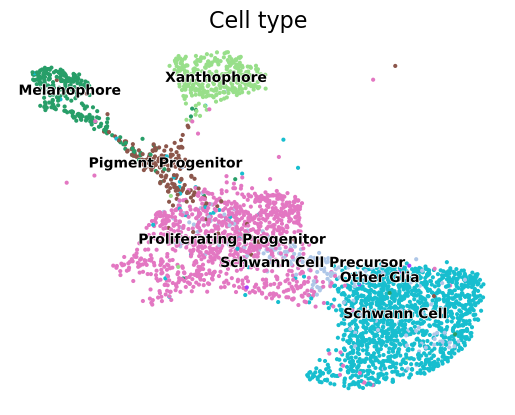

In [7]:
clusters = adata0.obs['Cell_type']
# adata0 = adata0[clusters != 'Other Glia']
clusters = adata0.obs['Cell_type']
scv.pl.scatter(adata0, color="Cell_type",basis='umap', fontsize=16, save=result_path+'clusters.png')

In [8]:
scv.pp.pca(adata0,n_comps=50)
# #-------data preprocessing: loop to remove zero and low variance genes
# while True:
#     k_nei=10
#     #adata=adata0.copy()
#     scv.pp.neighbors(adata0, n_neighbors=k_nei)
#     scv.pp.moments(adata0, n_pcs=50, n_neighbors=k_nei)
#     zero_gene_num = np.sum(np.sum(adata0.layers['Ms'],axis=0) == 0)
#     print('zero_gene_num',zero_gene_num)
#     if zero_gene_num == 0:
#         lowvar_num = np.sum(np.var(adata0.layers['Ms'],0)<1e-1)
#         print('lowvar_num',lowvar_num)
#         if lowvar_num == 0:
#             break/
#         else:
#             adata0 = adata0[:,(np.var(adata0.layers['Ms'],0)>1e-1)]
#     else:
#         adata0 = adata0[:,(np.sum(adata0.layers['Ms'],axis=0) != 0)]

## ------data preprocessing: single run
scv.pp.neighbors(adata0, n_neighbors=k_nei)
scv.pp.moments(adata0, n_pcs=50, n_neighbors=k_nei)

computing neighbors


d:\Anaconda\envs\pytorch\Lib\site-packages\pandas\core\algorithms.py:516: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps.dtype], [])


    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [9]:
# scv.pp.pca(adata0,n_comps=50)
scv.tl.velocity(adata0)
adata0
# scv.tl.velocity_graph(adata0)
# scv.tl.velocity_pseudotime(adata0)

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


d:\Anaconda\envs\pytorch\Lib\site-packages\scvelo\tools\optimization.py:173: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma[i] = np.linalg.pinv(A.T.dot(A)).dot(A.T.dot(y[:, i]))


AnnData object with n_obs × n_vars = 3386 × 600
    obs: 'split_id', 'sample', 'Size_Factor', 'condition', 'Cluster', 'Cell_type', 'umap_1', 'umap_2', 'batch', 'n_counts'
    var: 'n_cells', 'gene_count_corr', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'Cell_type_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap', 'velocity_params'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'Ms', 'Mu', 'spliced', 'unspliced', 'velocity', 'variance_velocity'
    obsp: 'connectivities', 'distances'

In [10]:
gene_arr=adata0.var.index.values
X_pca=adata0.obsm['X_pca']
# cell_vpt=adata0.obs['velocity_pseudotime'].values#cell_vpt = adata0.obs['latent_time'].values#
cell_vpt=adata0.obs['Size_Factor'].values
color_label = cell_vpt
Xs=adata0.layers['Ms']#adata.X.A#
X_pca.shape

(3386, 50)

In [172]:
cell_nei=adata0.uns['neighbors']['indices']
# cell_nei=adata0.obsp['distances'].indices.reshape([-1,k_nei-1])
def Nei_matrices(cell_nei,k_nei,adata):
    global row,col
    row =np.array([np.ones((k_nei,))*i for i in range(adata.shape[0])]).flatten()
    col=cell_nei.flatten()
    w_val=np.array([np.linalg.norm(X_pca[int(i),:]-X_pca[int(j),:]) for i,j in zip(row,col)])
    adj_val=np.ones(col.shape)
    dc=np.amax(w_val)
    nei_w=[]
    rho_arr=[]
    for i in range(cell_nei.shape[0]):
        dij=np.array([np.linalg.norm(X_pca[i,:]-X_pca[int(j),:]) for j in cell_nei[i]])
        rho=np.sum(np.exp(-dij**2/dc**2))
        nei_w.append(np.exp(-dij**2/dc**2)/rho)
        rho_arr.append(rho)
    rho_arr=np.array(rho_arr)/np.amax(rho_arr)
    nei_w=np.array(nei_w)
    A_mat=csr_matrix((adj_val, (row, col)), shape=(adata.shape[0], adata.shape[0]))
    W_mat=csr_matrix((w_val, (row, col)), shape=(adata.shape[0], adata.shape[0]))
    Nei_mat=csr_matrix((nei_w.flatten(), (row, col)), shape=(adata.shape[0], adata.shape[0]))
    return nei_w,A_mat,W_mat,Nei_mat
nei_w,A_mat,W_mat,Nei_mat = Nei_matrices(cell_nei,k_nei,adata0)


# from scipy.sparse import csr_matrix
# adata = adata0.copy()
# sc.pp.pca(adata, n_comps=50)
# sc.pp.neighbors(adata, n_neighbors=k_nei)
# scv.pp.moments(adata, n_pcs=50, n_neighbors=k_nei)
# scv.tl.velocity(adata)

# gene_arr = adata.var.index.values
# X_pca = adata.obsm['X_pca']
# X_umap = adata.obsm['X_umap']
# Xs = adata.layers['Ms'] #adata.X.A#
# # Xs = adata.layers['M_s'] #如果是EG_ab_dyn
# X = Xs

# row = np.array([np.ones((k_nei,))*i for i in range(adata.shape[0])]).flatten()
# col = (adata.obsp['distances']+csr_matrix(np.eye(adata.obsp['distances'].shape[0]))).indices
# w_val = np.array([np.linalg.norm(X_pca[int(i),:]-X_pca[int(j),:]) for i,j in zip(row,col)])
# adj_val = np.ones(col.shape)
# A_mat = csr_matrix((adj_val, (row, col)), shape=(adata.shape[0], adata.shape[0]))
# W_mat = csr_matrix((w_val, (row, col)), shape=(adata.shape[0], adata.shape[0]))

# dc=np.amax(adata.obsp['distances'])
# cell_nei=adata.obsp['distances'].indices.reshape([-1,k_nei-1])
# nei_w=[]
# rho_arr=[]
# for i in range(cell_nei.shape[0]):
#     dij=np.array([np.linalg.norm(X_pca[i,:]-X_pca[int(j),:]) for j in cell_nei[i]])
    
#     rho=np.sum(np.exp(-dij**2/dc**2))
#     nei_w.append(np.exp(-dij**2/dc**2)/rho)
#     rho_arr.append(rho)
# rho_arr=np.array(rho_arr)/np.amax(rho_arr)
# nei_w=np.array(nei_w)


In [12]:
# velocity = np.array(adata0.layers['velocity'])
# velocity_gene = adata0.var['velocity_genes']

In [13]:
def smooth_func(X_val,cell_nei=cell_nei,nei_w=nei_w):
    X_s=X_val.copy()
    for ci in range(len(X_val)):
        X_s[ci]=np.dot(X_val[cell_nei[ci,:]],nei_w[ci,:])
    return(X_s)

## Read

In [14]:
[k_nei,K,L] = [10,3,6]
subfolder = 'junda'
read_path = 'results/'+model_name+'/'+subfolder+'/' +f'k_nei={k_nei}/K={K} L={L}'+'/'
# GE_results = np.load(read_path+'GE_results.npz',allow_pickle=True)['arr_0'].item()

In [15]:
read_path

'results/zebrafish/junda/k_nei=10/K=3 L=6/'

In [16]:
encoder = torch.load(read_path+'encoder.pt')
X = Xs
GE_results = Get_GE_results(encoder,X,GE_eigen=None)

## Downstream

In [17]:
GE_results.keys()

dict_keys(['mu_learned', 'sigma_learned', 'latent_z', 'pMu_pX', 'pSgm_pX', 'Fisher_g'])

In [18]:
mu_learned = GE_results['mu_learned']
sigma_learned = GE_results['sigma_learned']
latent_z = GE_results['latent_z']
Fisher_g = GE_results['Fisher_g']
pMu_pX = GE_results['pMu_pX']
pSgm_pX = GE_results['pSgm_pX']

In [31]:
###
import numpy as np
from scipy.special import erf

def norm_abs_expect(mu, sigma):
    return sigma * np.sqrt(2/np.pi) * np.exp(-mu**2/(2*sigma**2)) + \
           mu * erf(mu/(np.sqrt(2)*sigma))

# 示例
print(norm_abs_expect(0, 1))   # 标准正态结果约为0.797885
print(norm_abs_expect(1, 2))   # mu=1, sigma=2结果

0.7978845608028654
1.7911862296052243


In [38]:
import ot

In [81]:
erf(3)

0.9999779095030014

In [93]:
def integral(x):
    dt = 0.000001
    t = np.arange(0, x, dt)
    return 2 * np.sum(np.exp(-t**2)) * dt /np.sqrt(np.pi)
x = 3
erf(x),integral(x)

(0.9999779095030014, 0.9999784736229589)

In [137]:
from scipy.special import erf
def W1_distance(mu1, sigma1, mu2, sigma2):
    """Compute the 1-Wasserstein distance between two Gaussian distributions.
    Args:
        mu1: Mean of the first Gaussian (numpy array).
        sigma1: Covariance matrix of the first Gaussian (numpy array).
        mu2: Mean of the second Gaussian (numpy array).
        sigma2: Covariance matrix of the second Gaussian (numpy array)."""
    mu = np.abs(mu1 - mu2)
    sigma = np.abs(sigma1 - sigma2)
    Wass_dis = sigma * np.sqrt(2/np.pi) * np.exp(-mu**2/(2*sigma**2)) + \
           mu * erf(mu/(np.sqrt(2)*sigma))
    return np.sum(Wass_dis)


In [138]:
# ###

# np.random.seed(42)

# N = 1000
# mu1, cov1 = [0, 0], [[1, 0], [0, 1]]
# mu2, cov2 = [1, 2], [[2, 0], [0, 20]]

# X = np.random.multivariate_normal(mu1, cov1, N)
# Y = np.random.multivariate_normal(mu2, cov2, N)
# sigma1 = np.sqrt(np.diag(cov1))
# sigma2 = np.sqrt(np.diag(cov2))


# # 概率分布权重（均匀分布）
# a = np.ones((N,)) / N
# b = np.ones((N,)) / N

# # pairwise 欧氏距离矩阵
# M = ot.dist(X, Y,p=1,metric='minkowski')  # shape (N, N)

# # 计算 Earth Mover's distance / Wasserstein-1
# emd_value = ot.emd2(a, b, M, numItermax=100000, return_matrix=False)
# print(f"Wasserstein-1 距离 (EMD): {emd_value:.4f}")
# print(W1_distance(np.array(mu1), sigma1, np.array(mu2), sigma2))

In [139]:
# def w1_quantile_mc(mu1, sigma1, mu2, sigma2, M=200000):
#     Z = np.random.randn(M)
#     X = mu1 + sigma1 * Z
#     Y = mu2 + sigma2 * Z
#     return np.mean(np.abs(X - Y))
# w1_quantile_mc(mu_learned[0,0], sigma_learned[0,0], mu_learned[1,0], sigma_learned[1,0])

In [140]:
# N = 10000
# for i in range(mu_learned.shape[1]):
#     X = np.random.normal(mu_learned[1,i], sigma_learned[1,i], N)
#     Y = np.random.normal(mu_learned[2,i], sigma_learned[2,i], N)
#     Z = np.random.normal(mu_learned[1,i]-mu_learned[2,i], np.abs(sigma_learned[1,i]-sigma_learned[2,i]), N)
#     print('MC',np.sum(np.abs(Z))/N)
#     a = np.ones((N,)) / N
#     b = np.ones((N,)) / N
#     M = ot.dist(X.reshape(N,1), Y.reshape(N,1), metric='euclidean')  # shape (N, N)
#     emd_value = ot.emd2(a, b, M, numItermax=100000, return_matrix=False)
#     print('POT:',emd_value,mu_learned[1,i], sigma_learned[1,i], mu_learned[2,i], sigma_learned[2,i])
#     print('calcu:',W1_distance(mu_learned[1,i], sigma_learned[1,i], mu_learned[2,i], sigma_learned[2,i]))
# print(W1_distance(mu_learned[1], sigma_learned[1], mu_learned[2], sigma_learned[2]))

In [175]:
row.shape
col.shape

(33860,)

In [176]:
cell_nei

array([[   0, 1079, 1175, ...,  724, 1820,  502],
       [   1, 2652, 2562, ..., 2606, 1494, 1248],
       [   2,  382, 2810, ..., 1027,  969,  641],
       ...,
       [3383, 3331, 3215, ..., 2982,  780, 3151],
       [3384, 3365, 1802, ..., 3385, 1771, 1729],
       [3385, 3363, 3384, ..., 1447, 3189, 3360]], dtype=int64)

In [184]:
cell_nei[inds[nei_k]][1:]

array([1079, 3069, 3125, 1690, 3062, 1347, 2643, 2993, 3182], dtype=int64)

In [187]:
zip(mx,my)

In [190]:
mx,my = cell_nei[self_ind][1:],cell_nei[inds[nei_k]][1:]
M = [Fisher_dist(mu_learned[i,:],sigma_learned[i,:],\
                        mu_learned[j,:],sigma_learned[j,:]) for i in mx for j in my]
np.array(M).reshape((k_nei-1,k_nei-1))

array([[1.47713639, 1.65311547, 1.53488539, 1.48094599, 1.42969592,
        1.31280889, 1.41945671, 1.69341179, 1.50857792],
       [1.41650832, 1.58902294, 1.47256433, 1.42025149, 1.36799862,
        1.25103935, 1.35642433, 1.62919986, 1.44479188],
       [1.50080759, 1.66726013, 1.55433497, 1.50801293, 1.45434319,
        1.33829877, 1.43870167, 1.69916293, 1.52356091],
       [1.30647294, 1.48192448, 1.36308597, 1.31133855, 1.25951357,
        1.14302902, 1.24793828, 1.52235856, 1.33790053],
       [1.08459419, 1.26947486, 1.1445483 , 1.08464095, 1.03617988,
        0.91952413, 1.02972555, 1.32187261, 1.1271422 ],
       [1.41857315, 1.59761438, 1.47910866, 1.42178233, 1.37109264,
        1.2535703 , 1.36395852, 1.64153275, 1.45305407],
       [1.73966028, 1.9025051 , 1.79297038, 1.75008472, 1.69466937,
        1.57915733, 1.67792604, 1.92776761, 1.75886069],
       [1.5591463 , 1.72546312, 1.61278506, 1.56510865, 1.51200102,
        1.39571803, 1.49689876, 1.75820232, 1.58194004],


In [195]:
M

array([[ 9.716426 , 10.853663 , 13.248318 , 12.070096 ,  9.800072 ,
        14.432594 ,  6.0929484, 12.782929 ,  9.671763 ],
       [ 8.2741585,  8.422712 , 11.630957 ,  9.872607 ,  8.221664 ,
        12.783222 ,  5.271872 , 11.080475 ,  7.734313 ],
       [ 9.163559 ,  5.2269187,  6.9669566,  5.8471384,  6.3584886,
         6.7426786,  6.8784184,  5.947273 ,  7.442125 ],
       [ 7.8408637,  5.645776 ,  7.9805365,  6.5400214,  5.7842593,
         7.575108 ,  5.0796885,  7.1237044,  6.108191 ],
       [ 6.0681505,  7.573126 ,  9.645636 ,  8.356316 ,  6.3449044,
        10.495007 ,  4.275262 ,  9.486077 ,  4.850828 ],
       [11.36999  , 13.3206415, 15.141013 , 14.28307  , 11.8109455,
        16.556581 ,  6.9055   , 15.012371 , 10.732365 ],
       [10.681636 ,  6.7475038,  7.9939494,  7.5838532,  8.427943 ,
         9.631578 ,  9.156216 ,  8.152519 ,  9.797382 ],
       [ 9.373919 ,  5.702207 ,  7.619639 ,  6.566928 ,  6.8982816,
         7.3339195,  7.07998  ,  6.6850514,  7.4780684],


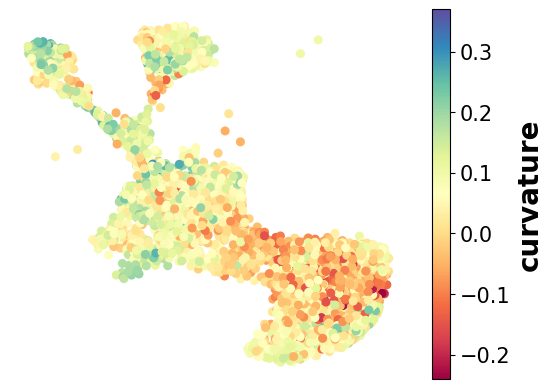

In [194]:
### expression space W1
### 注意X=Xs
import ot
X_plt,Y_plt = adata0.obsm['X_umap'][:,0],adata0.obsm['X_umap'][:,1]

cRc_arr_w1=[]
A = csr_matrix(A_mat + np.eye(A_mat.shape[0]))
for inds in np.split(A.indices, A.indptr)[1:-1]:
    # print(inds)
    self_ind=inds[0]

    cRc_w1=0
    for nei_k in range(1,len(inds)):
        dEu=np.linalg.norm(X[self_ind,:]-X[inds[nei_k],:])

        mx,my = cell_nei[self_ind][1:],cell_nei[inds[nei_k]][1:]
        
        a,b = np.ones((k_nei-1,)) / (k_nei-1), np.ones((k_nei-1,)) / (k_nei-1)

        M = ot.dist(X[mx,:], X[my,:], metric='euclidean')  # shape (N, N)

        dwa1 = ot.emd2(a, b, M, numItermax=100000, return_matrix=False)

        # print(dwa1,dFi,dWa)
        cRc_w1+=1-dwa1/dEu
    cRc_arr_w1.append(cRc_w1/len(inds))

cRc_arr_w1 = np.array(cRc_arr_w1)
crc_smooth_w1 = smooth_func(cRc_arr_w1)

idx = ~np.isnan(crc_smooth_w1)
cmap = plt.colormaps['Spectral']
plt.scatter(X_plt[idx],Y_plt[idx],c=crc_smooth_w1[idx],s=30,cmap=cmap)
plt.axis('off')
clb=plt.colorbar()
clb.ax.set_ylabel('curvature',fontsize=20,weight='bold')
clb.ax.tick_params(axis='y', labelsize=15)
# np.corrcoef(crc_smooth,crc_smooth_w1)

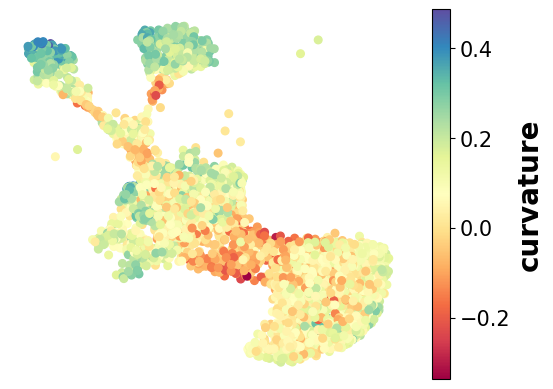

In [ ]:
### latent space W1
### 注意X=Xs
import ot
X_plt,Y_plt = adata0.obsm['X_umap'][:,0],adata0.obsm['X_umap'][:,1]

cRc_arr_w1=[]
A = csr_matrix(A_mat + np.eye(A_mat.shape[0]))
for inds in np.split(A.indices, A.indptr)[1:-1]:
    # print(inds)
    self_ind=inds[0]

    cRc_w1=0
    for nei_k in range(1,len(inds)):
        dFi=Fisher_dist(mu_learned[self_ind,:],sigma_learned[self_ind,:],\
                        mu_learned[inds[nei_k],:],sigma_learned[inds[nei_k],:])
        mx,my = cell_nei[self_ind][1:],cell_nei[inds[nei_k]][1:]
        a,b = np.ones((k_nei-1,)) / (k_nei-1), np.ones((k_nei-1,)) / (k_nei-1)

        M = [Fisher_dist(mu_learned[i,:],sigma_learned[i,:],\
                        mu_learned[j,:],sigma_learned[j,:]) for i in mx for j in my]
        M = np.array(M).reshape((k_nei-1,k_nei-1))
        dwa1 = ot.emd2(a, b, M, numItermax=100000, return_matrix=False)

        # print(dwa1,dFi,dWa)
        cRc_w1+=1-dwa1/dFi
    cRc_arr_w1.append(cRc_w1/len(inds))

cRc_arr_w1 = np.array(cRc_arr_w1)
crc_smooth_w1 = smooth_func(cRc_arr_w1)

idx = ~np.isnan(crc_smooth_w1)
cmap = plt.colormaps['Spectral']
plt.scatter(X_plt[idx],Y_plt[idx],c=crc_smooth_w1[idx],s=30,cmap=cmap)
plt.axis('off')
clb=plt.colorbar()
clb.ax.set_ylabel('curvature',fontsize=20,weight='bold')
clb.ax.tick_params(axis='y', labelsize=15)
# np.corrcoef(crc_smooth,crc_smooth_w1)

In [197]:
dEu=np.linalg.norm(X[self_ind,:]-X[inds[nei_k],:])
dEu**2,np.sum((X[self_ind,:]-X[inds[nei_k],:])**2)

(52.59208976307514, 52.59209)

array([[ 1.        , -0.28010372],
       [-0.28010372,  1.        ]])

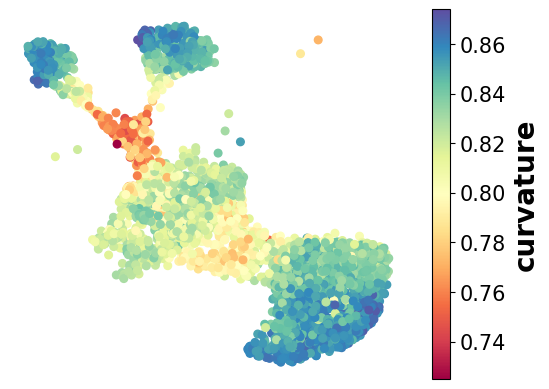

In [ ]:
### 注意X=Xs
X_plt,Y_plt = adata0.obsm['X_umap'][:,0],adata0.obsm['X_umap'][:,1]
cRc_arr=[]
cRc_arr_eu=[]
cRc_arr_w1=[]
A = csr_matrix(A_mat + np.eye(A_mat.shape[0]))
for inds in np.split(A.indices, A.indptr)[1:-1]:
    self_ind=inds[0]
    cRc=0
    cRc_eu=0
    cRc_w1=0
    for nei_k in range(1,len(inds)):

        dEu=np.linalg.norm(X[self_ind,:]-X[inds[nei_k],:])

        dFi=Fisher_dist(mu_learned[self_ind,:],sigma_learned[self_ind,:],\
                        mu_learned[inds[nei_k],:],sigma_learned[inds[nei_k],:])
        dWa=wasserstein_distance(mu_learned[self_ind,:],sigma_learned[self_ind,:],\
                        mu_learned[inds[nei_k],:],sigma_learned[inds[nei_k],:])
        dwa1=W1_distance(mu_learned[self_ind,:],sigma_learned[self_ind,:],\
                        mu_learned[inds[nei_k],:],sigma_learned[inds[nei_k],:])
        # print(dwa1,dFi,dWa)
        cRc+=1-dWa/dFi
        cRc_eu+=1-dWa/dEu
        cRc_w1+=1-dwa1/dFi
    cRc_arr.append(cRc/len(inds))
    cRc_arr_eu.append(cRc_eu/len(inds))
    cRc_arr_w1.append(cRc_w1/len(inds))
crc = np.array(cRc_arr)
crc_eu = np.array(cRc_arr_eu)
cRc_arr_w1 = np.array(cRc_arr_w1)
crc_smooth = smooth_func(crc_eu)
crc_smooth_w1 = smooth_func(cRc_arr_w1)

idx = ~np.isnan(crc_smooth)
cmap = plt.colormaps['Spectral']
plt.scatter(X_plt[idx],Y_plt[idx],c=crc_smooth[idx],s=30,cmap=cmap)
plt.axis('off')
clb=plt.colorbar()
clb.ax.set_ylabel('curvature',fontsize=20,weight='bold')
clb.ax.tick_params(axis='y', labelsize=15)
np.corrcoef(crc_smooth,crc_smooth_w1)

5.111518 0.6972068236743694 2.867880977084011
2.8963263 0.4042437352280213 1.5859807088877482
2.3014293 0.31259768469017696 1.2463020278866295
0.44951925 0.05908158133304947 0.2819496800437639
1.2494205 0.1728216022601077 0.6870275491057611
2.6790853 0.4213373756468221 1.56772058132464
1.8579595 0.27763408509566295 1.1299225892458042
2.3543024 0.3401304656623002 1.393318848256923
0.9932297 0.1407737755122251 0.5982502579115339
1.5591251 0.2577688070904323 0.9531504592460166
1.2771008 0.21022154566047777 0.7807401231887122
1.5506792 0.25613725924356245 0.9415049239427444
1.1843696 0.1886370480173066 0.6993874599823662
0.7756481 0.1191493311664769 0.4716134155308557
1.8427591 0.30502083071910824 0.9955458649683676
1.1147887 0.1915017448319366 0.6847155210620821
0.69039494 0.08771445415121962 0.38429824283252634
1.9342508 0.3236297919588607 1.1838903502838674
1.3583974 0.26707337405044324 0.7941842348707423
0.90363765 0.1235229814207505 0.48519600957658626
1.0616928 0.1764923516928577 0.5

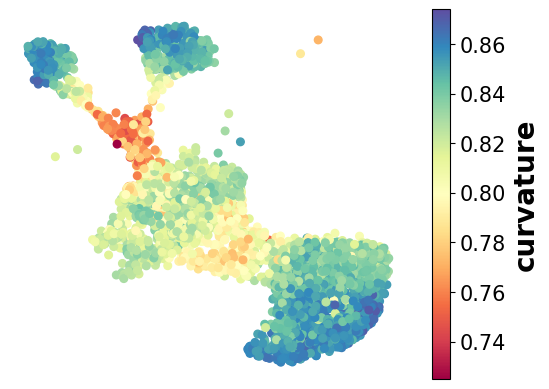

In [ ]:
### 注意X=Xs
X_plt,Y_plt = adata0.obsm['X_umap'][:,0],adata0.obsm['X_umap'][:,1]
cRc_arr=[]
cRc_arr_eu=[]
A = csr_matrix(A_mat + np.eye(A_mat.shape[0]))
for inds in np.split(A.indices, A.indptr)[1:-1]:
    self_ind=inds[0]
    cRc=0
    cRc_eu=0
    for nei_k in range(1,len(inds)):

        dEu=np.linalg.norm(X[self_ind,:]-X[inds[nei_k],:])
        dFi=Fisher_dist(mu_learned[self_ind,:],sigma_learned[self_ind,:],\
                        mu_learned[inds[nei_k],:],sigma_learned[inds[nei_k],:])
        dWa=wasserstein_distance(mu_learned[self_ind,:],sigma_learned[self_ind,:],\
                        mu_learned[inds[nei_k],:],sigma_learned[inds[nei_k],:])

        cRc+=1-dWa/dFi
        cRc_eu+=1-dWa/dEu

    cRc_arr.append(cRc/len(inds))
    cRc_arr_eu.append(cRc_eu/len(inds))
crc = np.array(cRc_arr)
crc_eu = np.array(cRc_arr_eu)
crc_smooth = smooth_func(crc_eu)

idx = ~np.isnan(crc_smooth)
cmap = plt.colormaps['Spectral']
plt.scatter(X_plt[idx],Y_plt[idx],c=crc_smooth[idx],s=30,cmap=cmap)
plt.axis('off')
clb=plt.colorbar()
clb.ax.set_ylabel('curvature',fontsize=20,weight='bold')
clb.ax.tick_params(axis='y', labelsize=15)

In [156]:
cRc_arr_w1[2]

0.7689454115927219

### Eigenvec

In [20]:
###### setting
new_para_name = 'eigengene'
# new_para_name = 'hotspot'
# new_para_name = ''

X_plt,Y_plt = adata0.obsm['X_umap'][:,0],adata0.obsm['X_umap'][:,1]
sonnodes = {'Proliferating Progenitor': ['Pigment Progenitor','Schwann Cell Precursor'],
            'Pigment Progenitor': ['Melanophore','Xanthophore'],
            'Schwann Cell Precursor': ['Schwann Cell'],
            'Schwann Cell': [],
            'Melanophore': [],
            'Xanthophore': []}
startnode = 'Proliferating Progenitor'

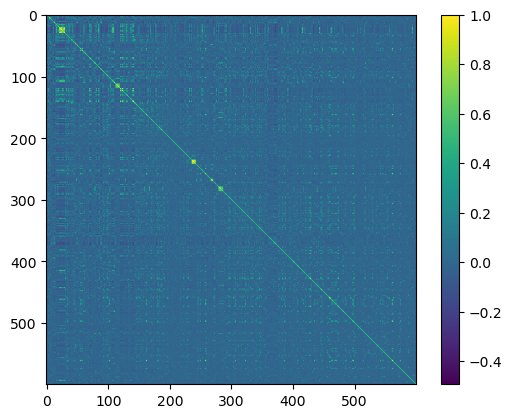

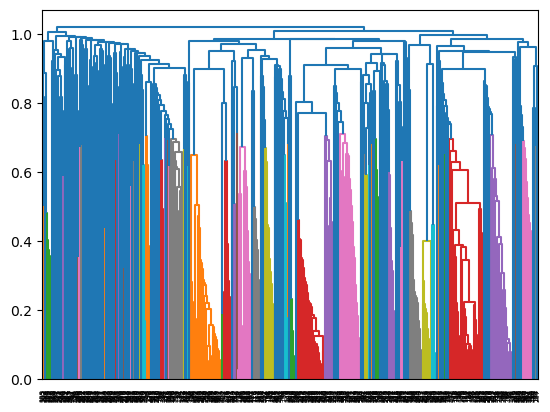

td: 0.9663195684552193


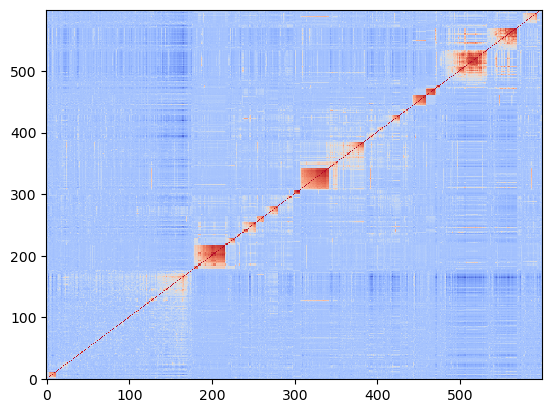

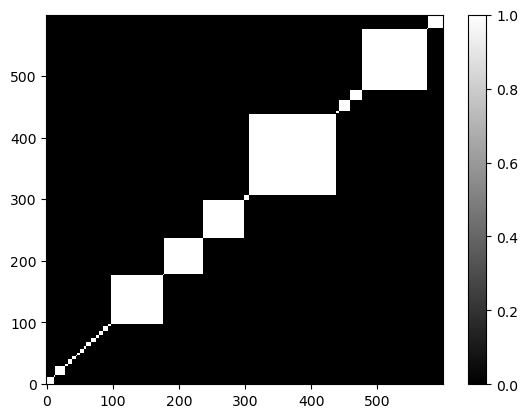

[0.6382159]
[0.69652474]
[0.608703]
[0.46590608]
[0.9990481]
[0.6733326]
[0.8063823]
[0.7309652]
[0.38744938]
[0.55937546]
[0.5191385]
[0.36344147]
[0.55469745]
[0.3343455]
[0.9711211]
[0.5169629]
[0.7592962]
[0.7787631]
[0.6181687]
[0.42959815]
[0.8345083]
[0.45174953]
[0.6726517]
[1.]
[0.6729932]
[0.4483303]
[0.7395673]
[0.75317436]
[1.]
X shape: (3386, 29)
[20 19 22 17 27 20 20 19 20 17 28 17 27 17 17 20 27 27 20 27 26 27 27 27
 27 27 27 27 27 27 27 22 22 27 22 19 27 20 27  5 27 20 20 27 20 19 22 19
 19  1 17 17 22 22  3 19 19 17 19 19 28 27 28 28 28  3 20 22 22 15 27 27
 27 26 20 12 22 17 22 20  6 27 17 17 27 27 22 20 17 17 17 20 20 22 25 22
  5  3 22 22 22 27 19 19 20 27 28 27 27 27 28 28 17 20 20 20 20 20 20 20
 27 27  4 27 27 22 27 20  1 17 27 27 27 25 22 15 27 19 27 27 27 27 27 20
 20 20 22 22 22 22 22 27 22 20 22 19 20 22 22 20 17 12 19 19 20 27 22 20
 17 27 22 22 20 22 28 22 17 27 27 22 22 19 25 28 22 17 25 25 22 20 20 22
 17 27 22 12 27 22 17  1  9 14 27  1  3 11 13 28 20 11

100%|██████████| 200/200 [00:00<00:00, 495.62it/s]


In [21]:
X = Xs

if new_para_name == 'PCA':
    X = X_pca
if new_para_name == 'eigengene':
    ## compute and save
    X,T_eigen = compute_x_eigen(X,method='average')
    print('X shape:',X.shape)
    print(T_eigen)
    np.save(result_path+f'T_{new_para_name}',T_eigen)
    np.save(result_path+'cell_eigengene_X'+'.npy',X)

    ### load
    # X = np.load('results/'+model_name+'/'+'cell_eigen_X'+'.npy')
    # X = X.astype(np.float32)
    encoder,pMu_pX,pSgm_pX = new_para(X,latent_z)
if new_para_name == 'eigengene_xiaohe':
    eigenname = 'data/eigengene/!EG_ab_dyn_processed10_nModule_7_eigengene_Power_9_deepSplit_1_minSize_10.csv'
    df = pd.read_csv(eigenname)
    df = df.drop('MEgrey',axis=1)
    df = np.array(df)
    print(df)
    # X = compute_x_eigen(X)
    X = df.astype(np.float32)
    encoder,pMu_pX,pSgm_pX = new_para(X,latent_z)
if new_para_name == 'hotspot':
    ### compute and save
    X = compute_x_hs(X,adata0,k_nei,threshold=int(Xs.shape[1]*0.05))
    X = X.astype(np.float32)
    np.save(result_path+'cell_hs_X'+'.npy',X)

    ### load
    # cell_hs_X = np.load('results/'+model_name+'/'+'cell_hs_X'+'.npy')
    # X = cell_hs_X.astype(np.float32)

    encoder,pMu_pX,pSgm_pX = new_para(X,latent_z)

In [22]:
stiffnum,diagFIgene,Eigenvec,Eigenval = FIM_new(pMu_pX,pSgm_pX,Fisher_g)

Calculating Fisher Information Matrix of genes...


100%|██████████| 3386/3386 [00:00<00:00, 7914.15it/s]


#### eigenvec setting

In [23]:
import scipy.spatial.distance as distance
def find_nearest_indices_voronoi(average_path, X_pca, k=30):
    """
    基于Voronoi分区的方法：
    对每个反应坐标点（average_path中的点），
    找出其Voronoi格子中距离最近的k个细胞索引。

    参数:
    ----------
    average_path : np.ndarray
        路径坐标, shape = [N_rc_points, dim] (通常是2维或PCA空间维度)
    X_pca : np.ndarray
        所有细胞的坐标, shape = [N_cells, dim]
    k : int
        每个Voronoi格子中选取的最近细胞数 (default: 30)

    返回:
    ----------
    cell_arr : list of lists
        每个元素是该RC点的最近邻细胞索引列表（在X_pca中的索引）
        与 find_nearest_indices() 返回格式完全一致
    """

    # 计算距离矩阵 [N_cells, N_rc_points]
    dist_matrix = distance.cdist(X_pca, average_path, 'euclidean')

    # 每个细胞最近的RC点索引（Voronoi分区）
    closest_rc = np.argmin(dist_matrix, axis=1)

    # 构建每个Voronoi cell包含的细胞索引
    cells_in_voronoi = {}
    for rc_i in range(average_path.shape[0]):
        idx_in_cell = np.where(closest_rc == rc_i)[0]
        cells_in_voronoi[rc_i] = idx_in_cell

    # 找出每个Voronoi cell中距离该RC点最近的k个细胞
    cell_arr = []
    for rc_i in range(average_path.shape[0]):
        idx_in_cell = cells_in_voronoi[rc_i]
        if len(idx_in_cell) == 0:
            cell_arr.append([])  # 该格子为空
            continue
        dist_to_rc = dist_matrix[idx_in_cell, rc_i]
        top_k_idx = idx_in_cell[np.argsort(dist_to_rc)[:k]]
        cell_arr.append(top_k_idx.tolist())

    return cell_arr

In [24]:
XY_plt = np.vstack([X_plt,Y_plt])
XY_plt.shape

(2, 3386)

In [25]:
# read_path = 'results/'+model_name+'/'#+f'{subfolder}/'#+ f'k_nei={k_nei}/'
RC = np.load('results/'+model_name+'/'+'RC_npy/zebrafish_dynamo_part_Schwann Cell_P2M_rc_nrc_7_dpca_10.npy')
# RC = np.load('results/'+model_name+'/'+'RC_npy/zebrafish_dynamo_part_Xanthophore_P2M_rc_nrc_5_dpca_10.npy')
# RC = np.load('results/'+model_name+'/'+'RC_npy/zebrafish_dynamo_part_Melanophore_P2M_rc_nrc_5_dpca_10.npy')



In [26]:
def find_nearest_indices_voronoi2(adata, path0, n_nei = 30, dpca = 10):
    cells_2d = adata.obsm["X_pca"]  
    path_2d = path0           
    cells_2d = adata.obsm["X_pca"][:,:dpca]
    path_2d = path0[:,:dpca]
    dist_matrix = distance.cdist(cells_2d, path_2d)  # [N_cells, N_rc_points]
    closest_rc = np.argmin(dist_matrix, axis=1)      # 每个细胞对应的RC索引
    cells_in_voronoi = {} 
    for rc_i in range(path_2d.shape[0]):
        idx_in_cell = np.where(closest_rc == rc_i)[0]
        cells_in_voronoi[rc_i] = idx_in_cell
    nearest_30_cells = []  # nearest_30_cells里存的是筛选到的对应每个RC紧挨着的n_nei个细胞。
    nearest_cell = []  # nearest_cell 存的是每个RC最近邻的细胞。
    for rc_i in range(path_2d.shape[0]):
        idx_in_cell = cells_in_voronoi[rc_i]
        if len(idx_in_cell) == 0:
            nearest_30_cells[rc_i] = np.array([])
            nearest_cell[rc_i] = np.array([])
            continue
        dist_to_rc = dist_matrix[idx_in_cell, rc_i]
        nearest_30_cells.append(idx_in_cell[np.argsort(dist_to_rc)[:n_nei]])
        nearest_cell.append(idx_in_cell[np.argsort(dist_to_rc)[0]])
    return nearest_30_cells, nearest_cell

# cell_arr, nearest_cell = find_nearest_indices_voronoi2(adata0, RC, n_nei = 50, dpca = RC.shape[1])
cell_arr, nearest_cell = find_nearest_indices_voronoi2(adata0, RC, n_nei = 30, dpca = RC.shape[1])

In [27]:
# cell_arr = find_nearest_indices_voronoi(RC, X_pca[:,:RC.shape[1]], k=15)
clusters_nei = np.ones(len(adata0),dtype=np.int8)
clusters_nei = list(-clusters_nei)
for i in range(len(cell_arr)):
    for j in cell_arr[i]:
        clusters_nei[j] = f'RC{i+1}'
clusters_nei = np.array(clusters_nei)
clusters_nei
# np.save(read_path+'clusters_rc.npy',clusters_nei)

array(['-1', '-1', '-1', ..., '-1', '-1', '-1'], dtype='<U4')

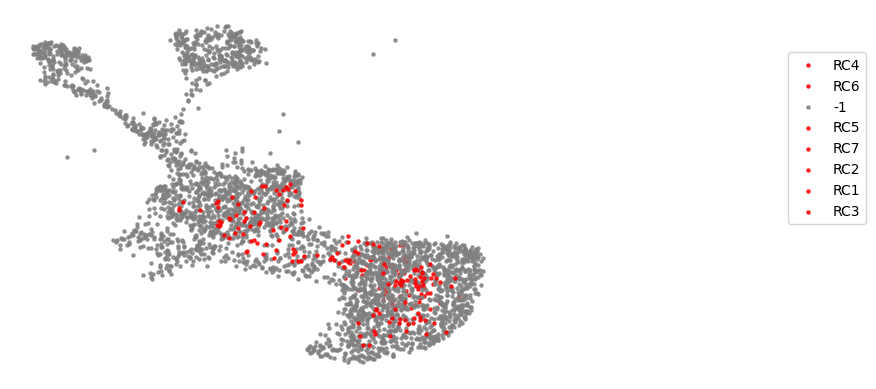

In [28]:
path_name = ''
path_name = 'RC_P2S_xiaohe/'
# path_name = 'RC_P2X_xiaohe/'
# path_name = 'RC_P2M_xiaohe/'


read_path = 'results/'+model_name+'/'+f'{subfolder}/'#+ f'k_nei={k_nei}/'
## clusters choice
result_path = 'results/'+model_name+'/'+subfolder+'/' +f'k_nei={k_nei}/K={K} L={L}'+'/'
result_path_eigenvec = result_path +f'{path_name}'+f'{new_para_name}_Eigenvec/'
folder = os.path.exists(result_path_eigenvec)
if not folder:                   #判断是否存在文件夹如果不存在则创建为文件夹
    os.makedirs(result_path_eigenvec)
    

clusters = adata0.obs['Cell_type'] ##在这行是之后使用的细胞聚类方法，可以自行更换比如PAGA
if 'RC' in path_name: ## 使用RC进行路径分析
    clusters = clusters_nei
    # clusters = np.load('results/'+model_name+'/'+'clusters_rc.npy')
    np.random.seed(42)
    for k,i in enumerate(set(clusters)):
        if i == str(-1):
            plt.scatter(X_plt[clusters==i],Y_plt[clusters==i],c='grey' ,s= 5,alpha=0.8,
                    cmap='Spectral',label=f'{i}')
        else:
            plt.scatter(X_plt[clusters==i],Y_plt[clusters==i],c='red' ,s= 5,alpha=0.8,
                    cmap='Spectral',label=f'{i}')
    plt.legend(bbox_to_anchor=(1.74,0.4),loc='lower right')
    plt.axis('off')
    # plt.savefig(result_path+'clusters_eigenvec.png',bbox_inches='tight')
    plt.show()
categories = np.unique(clusters)
eigenvec={}
for i in categories:
    eigenvec[i] = Eigenvec[clusters==i]

In [29]:
X_min = np.min(X_plt)
X_max = np.max(X_plt)
Y_min = np.min(Y_plt)
Y_max = np.max(Y_plt)
X_len = (X_max-X_min)/5
Y_len = (Y_max-Y_min)/5
wid = min(X_len,Y_len)/30
X_ori = X_min-wid*10
Y_ori = Y_min-wid*10

C:\Users\WINDOWS\AppData\Local\Temp\ipykernel_51572\4230462779.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cool_cmap = plt.cm.get_cmap('cool')


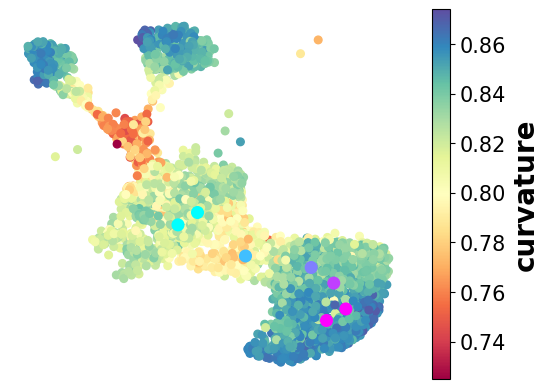

In [30]:
# 加载数据
# average_path = RC
average_path = XY_plt.T[nearest_cell]

# 绘制曲率背景
idx = ~np.isnan(crc_smooth)
cmap = plt.colormaps['Spectral']
plt.scatter(X_plt[idx], Y_plt[idx], c=crc_smooth[idx], s=30, cmap=cmap)
clb = plt.colorbar()
clb.ax.set_ylabel('curvature', fontsize=20, weight='bold')
clb.ax.tick_params(axis='y', labelsize=15)
plt.axis('off')

# 绘制渐变色路径
n_points = len(average_path)
colors = np.linspace(0, 1, n_points)
plt.scatter(average_path[1:-1, 0], average_path[1:-1, 1],
            c=colors[1:-1], cmap='cool', s=70)

cool_cmap = plt.cm.get_cmap('cool')

# 提取两端颜色（0表示左端，1表示右端）
start_end_color = cool_cmap((0,255))     # RGBA格式


# 绘制起始点（带start标签）
plt.scatter(average_path[0:1, 0], average_path[0:1, 1],
            c=start_end_color[0], s=70, label='start')

# 绘制终点（带end标签）
plt.scatter(average_path[-1:, 0], average_path[-1:, 1],
            c=start_end_color[1], s=70, label='end')


# 坐标轴箭头和标签（保持原代码）
# plt.arrow(X_ori - wid / 2, Y_ori, X_len, 0, width=wid, color='black', head_width=5 * wid)
# plt.arrow(X_ori, Y_ori - wid / 2, 0, Y_len, width=wid, color='black', head_width=5 * wid)
# plt.text(X_ori + X_len / 2, Y_ori - wid * 14, '$PCA_1$', fontsize=14, ha='center', weight='bold')
# plt.text(X_ori - wid * 17, Y_ori + Y_len / 2, '$PCA_2$', fontsize=14, ha='center', weight='bold')
# plt.arrow(X_ori-wid/2,Y_ori,X_len,0,width=wid,color='black',head_width=5*wid)
# plt.arrow(X_ori,Y_ori-wid/2,0,Y_len,width=wid,color='black',head_width=5*wid)
# plt.text(X_ori+X_len/2,Y_ori-wid*14,'$PCA_1$',fontsize=14,ha='center',weight='bold')
# plt.text(X_ori-wid*25,Y_ori+Y_len/2,'$PCA_2$',fontsize=14,ha='center',weight='bold')

# 保存图像
# plt.legend(loc='best')
plt.savefig(result_path+f'Figure4_{path_name[:-1]}.png', dpi=1200, bbox_inches='tight')
plt.show()

In [ ]:
for i in range(X.shape[1]):
    print(np.sum(my_Rearrange(T_eigen)==i+1))

131
99
79
62
58
23
17
17
15
12
8
8
7
7
7
6
6
5
5
4
4
4
4
4
2
2
2
1
1


In [ ]:
# result_path = 'results/'+model_name+'/'+subfolder+'/' +f'k_nei={k_nei}/K={K} L={L}'+'/'
# result_path_eigenvec = result_path +f'{new_para_name}_Eigenvec/'
# folder = os.path.exists(result_path_eigenvec)
# if not folder:                   #判断是否存在文件夹如果不存在则创建为文件夹
#     os.makedirs(result_path_eigenvec)

In [ ]:
# read_path = 'results/'+model_name+'/'+f'{subfolder}/k_nei={k_nei}/'#+ f'k_nei={k_nei}/'
# clusters = adata0.obs['Cell_type'] ##在这行是之后使用的细胞聚类方法，可以自行更换比如PAGA
# if 'beta' in result_path_eigenvec:
#     clusters = np.load(read_path+'EG_rc_beta_nei.npy') 
# elif 'alpha' in result_path_eigenvec:
#     clusters = np.load(read_path+'EG_rc_alpha_nei.npy')
# categories = np.unique(clusters)
# eigenvec={}
# for i in categories:
#     eigenvec[i] = Eigenvec[clusters==i]

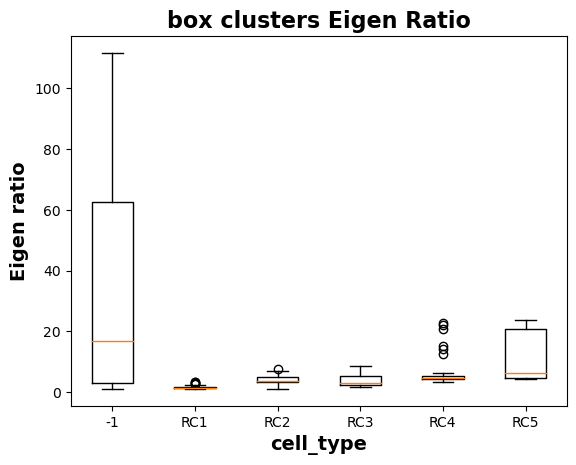

In [ ]:
##画图，前2特征值比值图
PLT_box(clusters,(Eigenval[:,0]/Eigenval[:,1]).reshape((X.shape[0],1)),save_path=result_path_eigenvec+f'box Eigen Ratio {new_para_name}'+'.png',
           ylabel='Eigen ratio',title_name='box clusters Eigen Ratio',cell_sort=None)

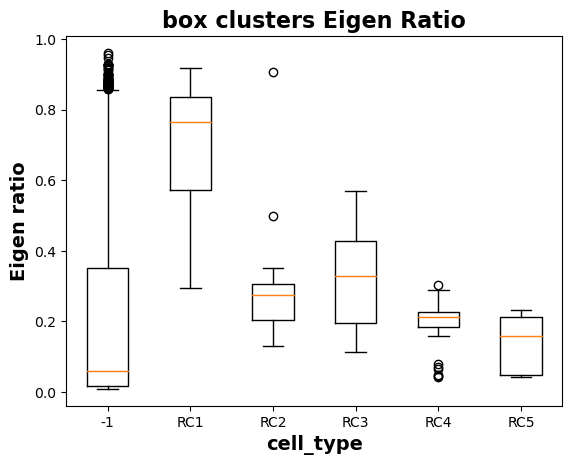

In [ ]:
##画图，前2特征值比值图
PLT_box(clusters,(Eigenval[:,1]/Eigenval[:,0]).reshape((X.shape[0],1)),save_path=result_path_eigenvec+f'box Eigen Ratio_inv {new_para_name}'+'.png',
           ylabel='Eigen ratio',title_name='box clusters Eigen Ratio',cell_sort=None)

#### vector clustering and gurobi

In [ ]:
from GE_utils import hierarchical_clustering
def angle_cdf_cos(t0, n):
    # t0: cos(theta_0)，注意t0∈[-1,1]
    # 累积分布函数，给定余弦阈值返回概率
    # 分子：t从t0到1
    num = quad(lambda t: (1-t**2)**((n-3)/2), -t0, t0)[0]
    den = quad(lambda t: (1-t**2)**((n-3)/2), -1, 1)[0]
    return num/den

def find_cos_for_prob(n, p, tol=1e-8):
    # 二分查找 t0，使CDF达到p
    f = lambda t0: angle_cdf_cos(t0, n) - p
    # t0 ∈ [-1, 1], 探索左侧小概率
    return bisect(f, 0, 1, xtol=tol)

In [ ]:
find_cos_for_prob(X.shape[1], 0.95)

0.3610069081187248

29 0.6389930918812752


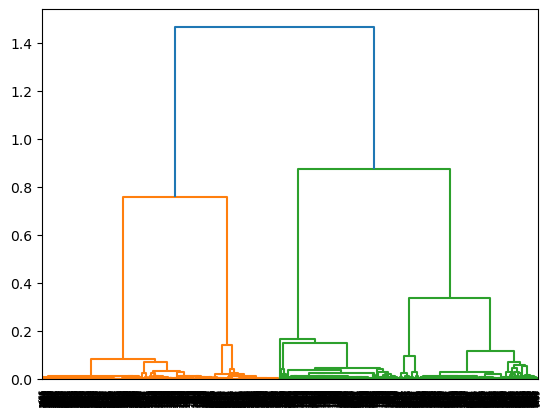

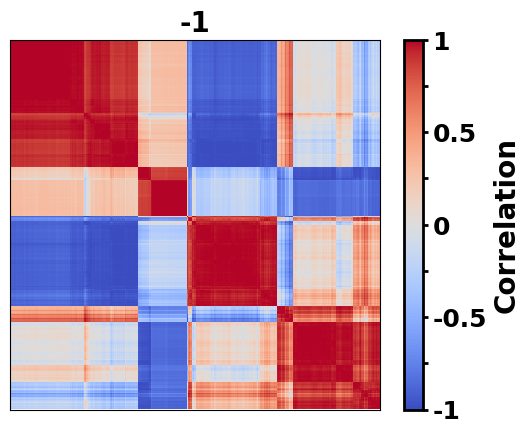

[4 4 3 ... 2 1 3]


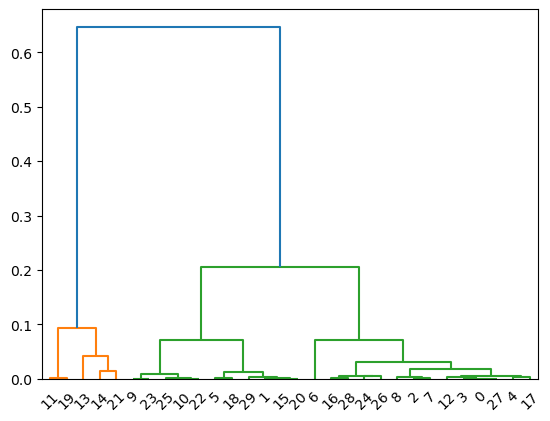

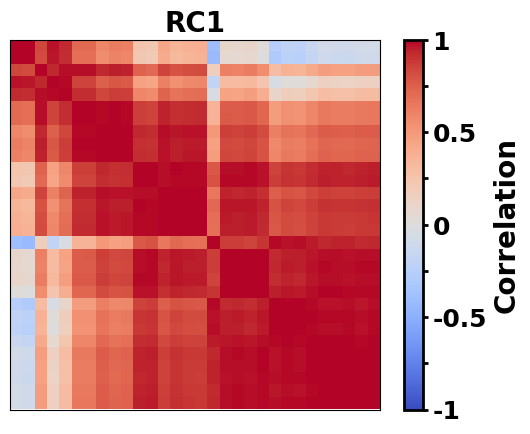

[2 2 2 2 2 2 2 2 2 2 2 1 2 1 1 2 2 2 2 1 2 1 2 2 2 2 2 2 2 2]


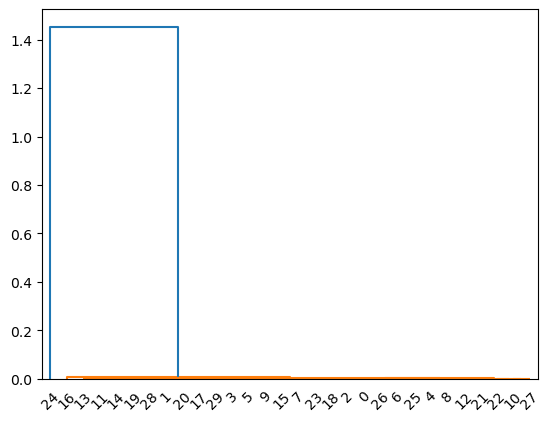

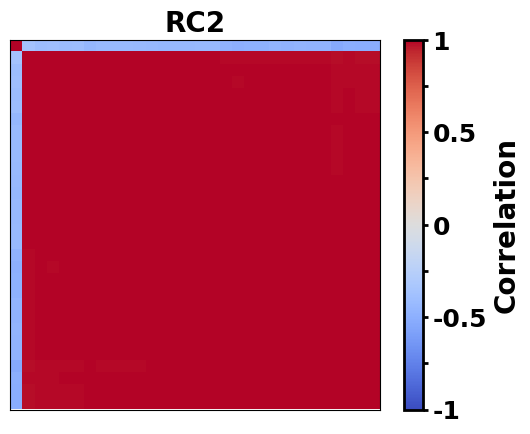

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1]


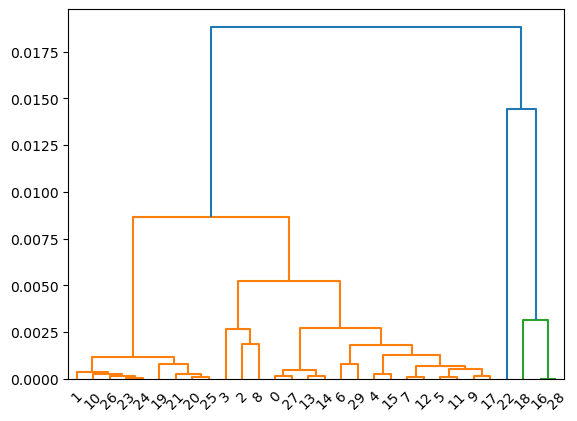

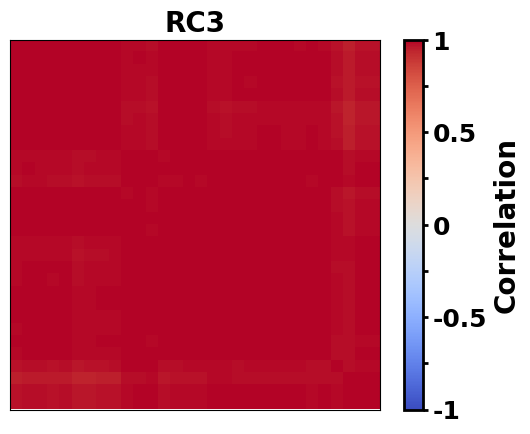

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


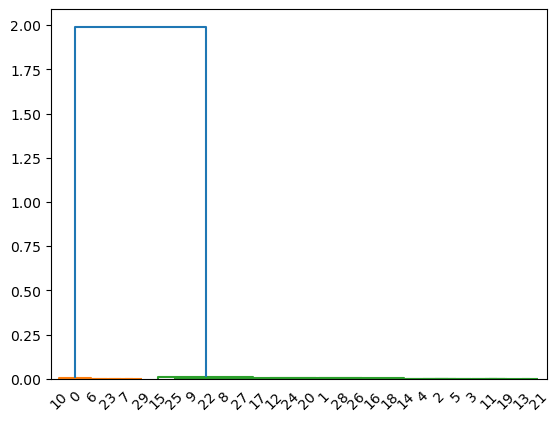

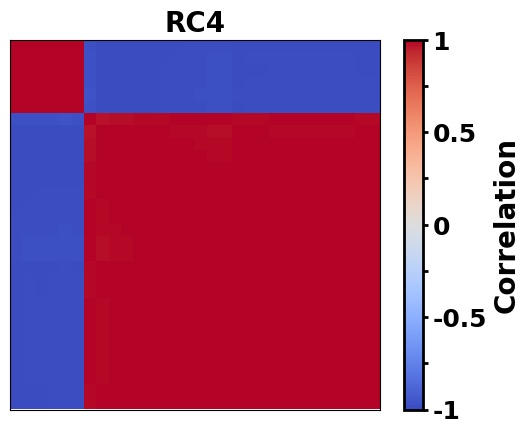

[1 2 2 2 2 2 1 1 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 1]


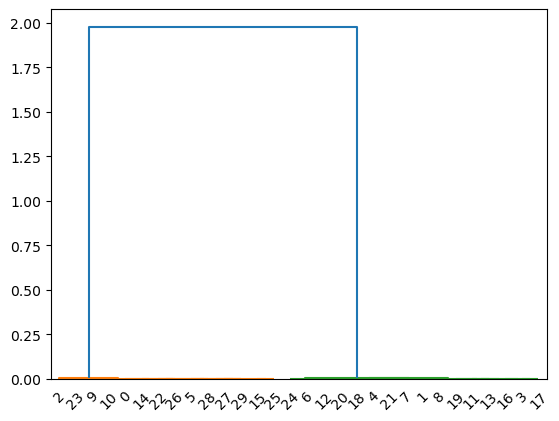

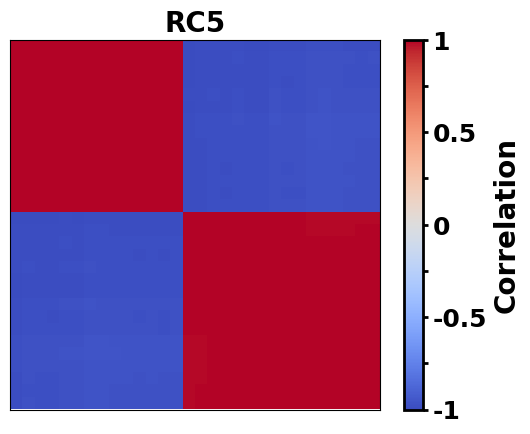

[1 2 1 2 2 1 2 2 2 1 1 2 2 2 1 1 2 2 2 2 2 2 1 1 2 1 1 1 1 1]


In [ ]:
###Before optimize the cosdistance
t = 1 - find_cos_for_prob(X.shape[1], 0.95)
print(X.shape[1],t)
TT = hierarchical_clustering(categories,eigenvec,t,result_path_eigenvec)

In [ ]:
import numpy as np
import gurobipy as gp
from gurobipy import GRB ##去官网申请权限
def GRBopt(Eigenvec):
    n = len(Eigenvec)
    np.random.seed(42)
    X = Eigenvec@Eigenvec.T
    # Create model
    m = gp.Model("binary_quadratic")
    m.setParam('Seed', 42)
    # Create binary variables (will be transformed to {-1,1})
    b = m.addVars(n, vtype=GRB.BINARY, name="b")

    # Set objective: min sum_{i,j} c_i c_j x_{ij}
    # where c_i = 2b_i - 1 transforms binary variables to {-1,1}
    obj = gp.QuadExpr()
    for i in range(n):
        for j in range(n):
            # Expand (2b_i - 1)(2b_j - 1)x_{ij}
            obj += -4 * X[i,j] * b[i] * b[j]  # quadratic term
            obj += 2 * X[i,j] * b[i]        # linear terms
            obj += 2 * X[i,j] * b[j]
            obj += -X[i,j]                    # constant term

    m.setObjective(obj, GRB.MINIMIZE)

    m.params.TimeLimit = 20*60  # 20 minutes time limit
    # Optimize
    m.optimize()

    # # Extract solution
    # if m.status == GRB.OPTIMAL:
    #     # Convert binary solution back to {-1,1}
    #     c = [2 * b[i].x - 1 for i in range(n)]
    #     print("Optimal solution found:")
    #     print("c =", c)
    #     print("Objective value =", m.objVal)
    #     return c
    # else:
    #     print("No optimal solution found")
    if m.status in [GRB.OPTIMAL, GRB.TIME_LIMIT, GRB.SUBOPTIMAL]:
        c = [2 * b[i].x - 1 for i in range(n)]
        print("Best feasible solution found:")
        print("c =", c)
        print("Objective value =", m.objVal)
        if m.status == GRB.TIME_LIMIT:
            print("Warning: reached time limit, solution may not be provably optimal.")
        return c
    else:
        print("No feasible solution was found")
        return None

In [ ]:
eigenvec={}
for i in categories:
    if i == str(-1):
        eigenvec[i] = Eigenvec[clusters==i]
        continue
    c = GRBopt(Eigenvec[clusters == i])
    if c is None:
        c = [1 for _ in range(Eigenvec[clusters==i].shape[0])]
    eigenvec[i] = np.diag(c)@Eigenvec[clusters==i]

Set parameter LicenseID to value 2632831
Set parameter Seed to value 42
Set parameter TimeLimit to value 1200
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (22631.2))

CPU model: AMD Ryzen 5 9600X 6-Core Processor, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
TimeLimit  1200
Seed  42

Optimize a model with 0 rows, 30 columns and 0 nonzeros
Model fingerprint: 0xbdfcd621
Model has 465 quadratic objective terms
Variable types: 0 continuous, 30 integer (30 binary)
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [3e+01, 1e+02]
  QObjective range [5e-02, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -664.1965936
Presolve time: 0.00s
Presolved: 406 rows, 436 columns, 1218 nonzeros
Variable types: 0 continuous, 436 integer (436 binary)

Root relaxation: cutoff, 28 iterations, 0.00 

In [ ]:
np.max(1-(eigenvec['RC1']@eigenvec['RC1'].T)),t

(1.4221678663984083, 0.6389930918812752)

0.6389930918812752 0.6389930918812752 29


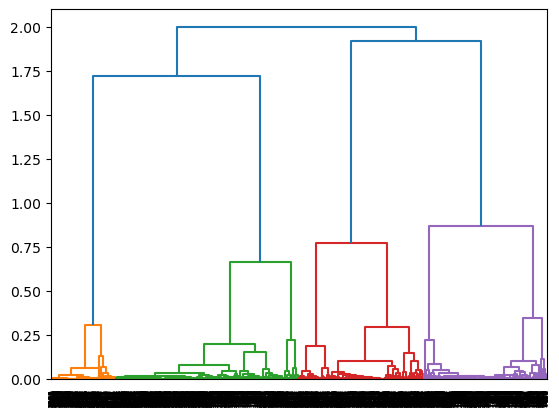

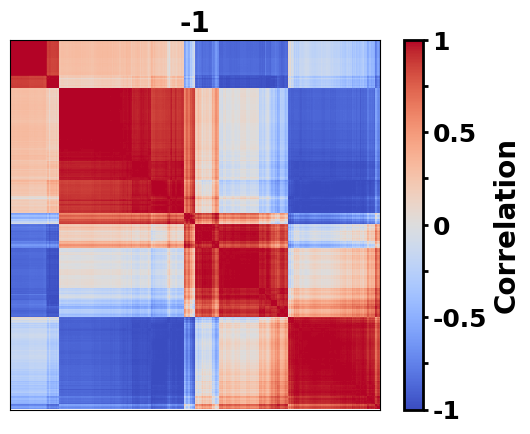

[5 5 7 ... 1 2 6]


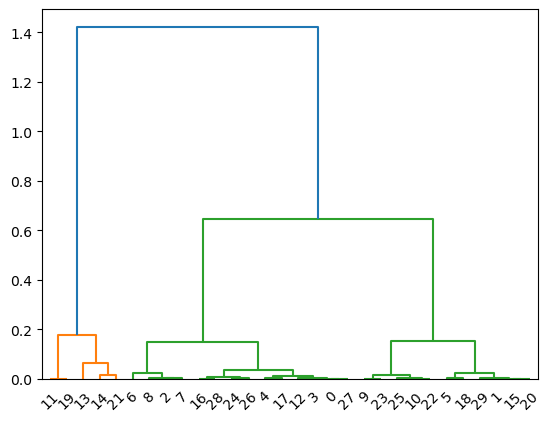

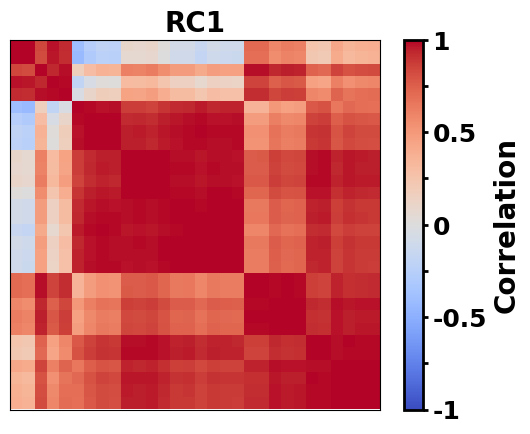

[2 3 2 2 2 3 2 2 2 3 3 1 2 1 1 3 2 2 3 1 3 1 3 3 2 3 2 2 2 3]


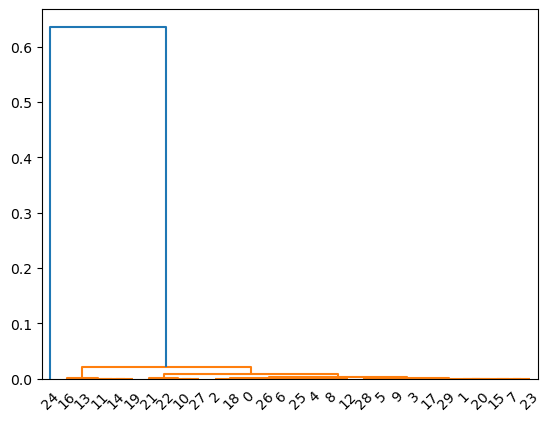

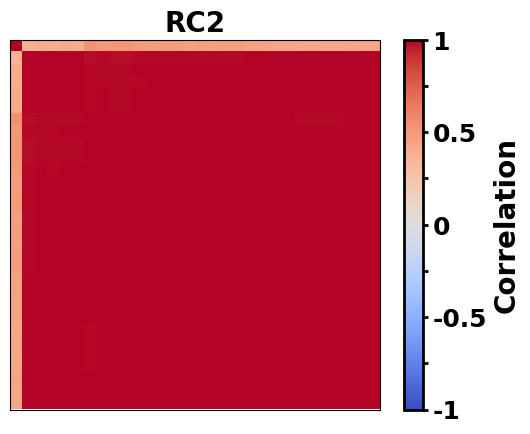

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


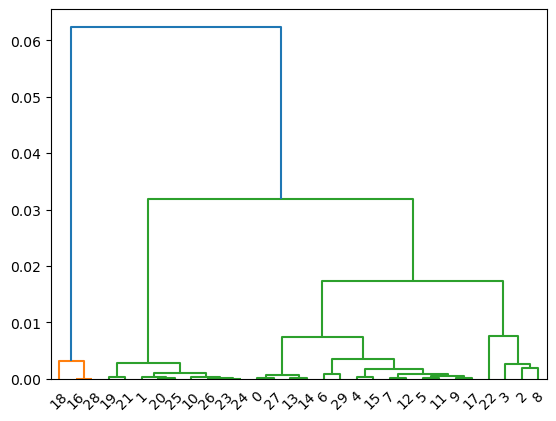

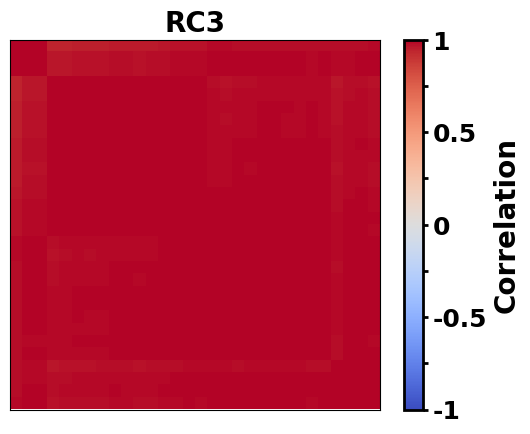

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


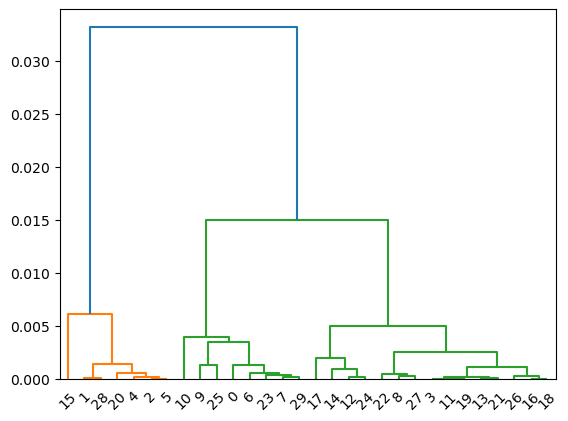

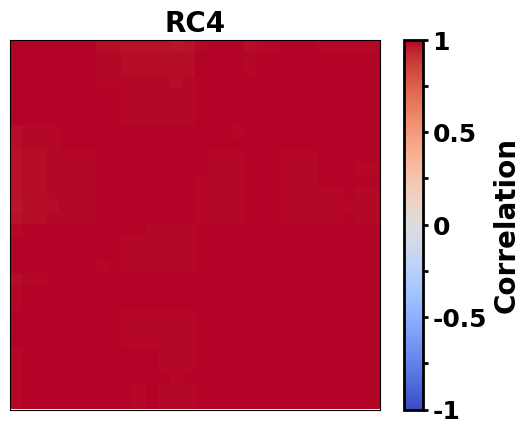

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


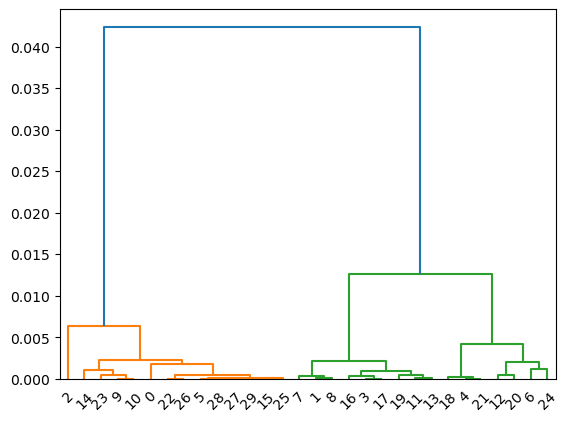

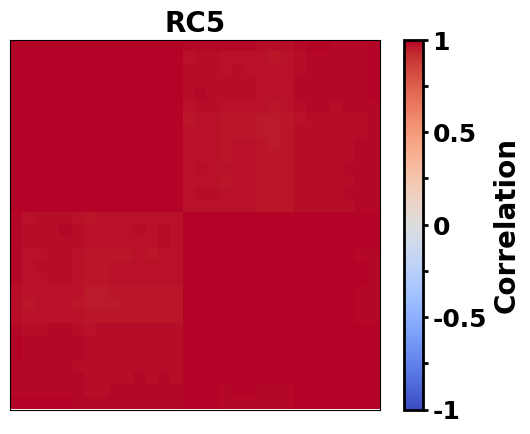

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [ ]:
###After optimize the cosdistance. cluster threshold is t
# t_new = 1 - np.cos(np.pi/6)#threshold                    自行选择
# t = 1 - 1.9/2#threshold                    自行选择
t_new = max(t,1-np.cos(np.pi/6))
# t_new = min(t_new,1-np.cos(np.pi/4))
print(t,t_new,X.shape[1])
TT = hierarchical_clustering(categories,eigenvec,t_new,result_path_eigenvec,method='complete',save_name='Corr_new')


In [ ]:
result_path_eigenvec

'results/zebrafish/junda/k_nei=10/K=3 L=6/RC_P2M_xiaohe/eigengene_Eigenvec/'

In [ ]:
for i in categories:
    TT[i] = my_Rearrange(TT[i])

[14, 11, 5] [1, 2, 3]
[30] [1]
[30] [1]
[30] [1]
[30] [1]


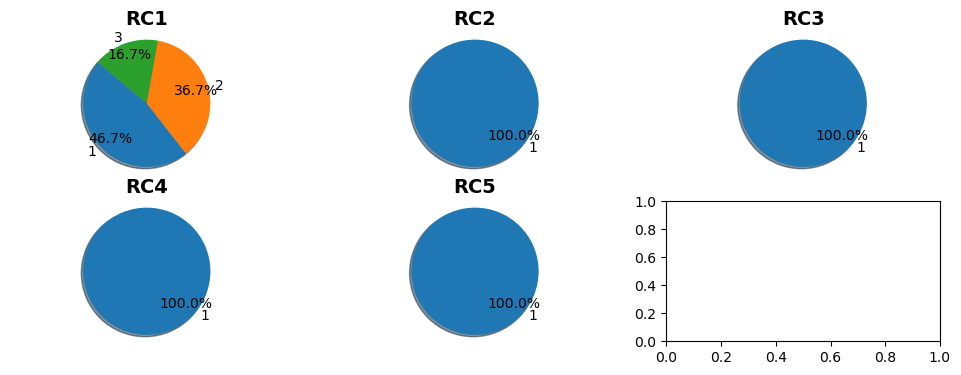

In [ ]:
def regroup_small_categories(counts, labels, threshold=5):
    """
    按照百分比将后占比小于 threshold 的类别合并为'others'
    counts: list，计数（已降序）
    labels: list，类别标签（与counts一一对应）
    """
    counts = np.array(counts)
    labels = np.array(labels)
    total = counts.sum()
    percent = counts / total * 100

    keep = []
    others_sum = 0
    for i in range(len(counts)):
        if percent[i] >= threshold or i == 0:  # 保证至少保留最大一个
            keep.append(i)
        else:
            others_sum += counts[i]
    new_counts = list(counts[keep])
    new_labels = list(labels[keep])
    if others_sum > 0:
        new_counts.append(others_sum)
        new_labels.append('Others')
    return new_counts, new_labels

def autopct_func(pct):
    return ('%1.1f%%' % pct) if pct >= 2 else ''

import math
##聚类结果的饼图显示
nc = len(categories)
row = int(np.sqrt(nc))
col = math.ceil(nc/row)
fig, axs = plt.subplots(row, col,figsize = (12,4))
k = 0
for i in categories:
    if i == 'Other Glia' or i == str(-1):
        continue
    # 原始计数和标签
    raw_counts = [np.sum(TT[i] == j) for j in set(TT[i])]
    raw_labels = list(set(TT[i]))
    # 按计数降序排序
    sorted_indices = np.argsort(raw_counts)[::-1]
    counts = [raw_counts[idx] for idx in sorted_indices]
    labels = [raw_labels[idx] for idx in sorted_indices]
    # 合并后5%的类别
    new_counts, new_labels = regroup_small_categories(counts, labels, threshold=2)
    print(new_counts, new_labels)
    # 画图
    axs[k // col, k % col].pie(
        new_counts,
        labels=new_labels,
        autopct=autopct_func,
        shadow=True,
        startangle=140,
        pctdistance=0.8,
        labeldistance=1.1
    )
    axs[k // col, k % col].axis('equal')
    axs[k // col, k % col].set_title(f'{i}', fontsize=14, weight='bold')
    k += 1

In [ ]:
len(categories) - (str(-1) in categories)
nc,row,col

(6, 2, 3)


cluster number of RC1 3
num of 1 type in RC1: 14
num of 2 type in RC1: 11
num of 3 type in RC1: 5

cluster number of RC2 1
num of 1 type in RC2: 30

cluster number of RC3 1
num of 1 type in RC3: 30

cluster number of RC4 1
num of 1 type in RC4: 30

cluster number of RC5 1
num of 1 type in RC5: 30


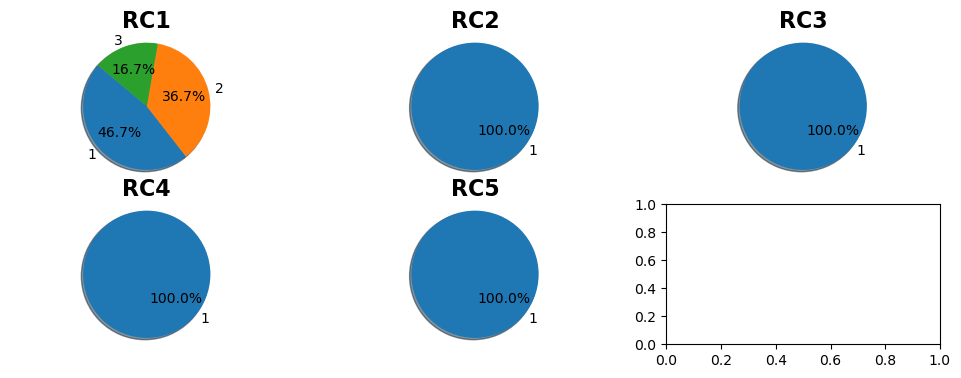

In [ ]:
##聚类结果的饼图显示
nc = len(categories) - (str(-1) in categories)
row = int(np.sqrt(nc))
col = int(np.ceil(nc/row))
# row,col = 2,5
fig, axs = plt.subplots(row, col,figsize = (12,4))
k = 0
for i in categories:
    if i == 'Other Glia' or i == str(-1):
        continue
    print('')
    print(f'cluster number of {i}',len(set(TT[i])))
    for j in set(TT[i]):
        print(f'num of {j} type in {i}:',np.sum(TT[i] == j))
    axs[k//col,k%col].pie([np.sum(TT[i] == j) for j in set(TT[i])], labels=set(TT[i]), autopct='%1.1f%%', shadow=True, startangle=140)
    axs[k//col,k%col].axis('equal')  # 确保饼图是圆形的
    axs[k//col,k%col].set_title(f'{i}',fontsize=16,weight='bold')
    k+=1
# plt.title('Clustering of eigenvectors on different cell',fontsize=20,weight='bold')
plt.savefig(result_path_eigenvec+f'pie_eigenvector{t}.png')
plt.show()


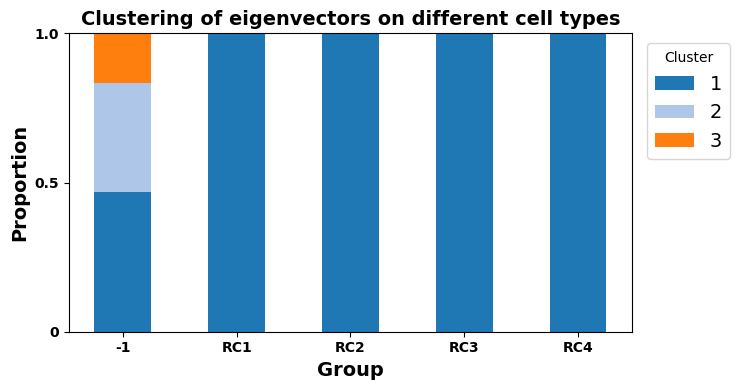

In [ ]:
# 统计各组类别数量
group_names = []  # 保存组名
class_names = set()  # 所有出现过的类别
group_class_count = {}

for i in categories:
    if i == str(-1):
        continue
    group_names.append(f"{i}")
    values, counts = np.unique(TT[i], return_counts=True)
    group_class_count[i] = dict(zip(values, counts))
    class_names.update(values)

class_names = sorted(list(class_names))

# 构造比例矩阵
count_matrix = []
for i in categories:
    if i == str(-1):
        continue
    total = sum(group_class_count[i].get(j, 0) for j in class_names)
    # 转为比例
    row = [group_class_count[i].get(j, 0) / total if total > 0 else 0 for j in class_names]
    count_matrix.append(row)

count_matrix = np.array(count_matrix)  # shape: n_groups × n_classes

# 绘制100%堆叠柱状图
fig, ax = plt.subplots(figsize=(len(group_names)*1.5, 4))

bottom = np.zeros(len(group_names))
colors = plt.cm.tab20.colors  # 配色，可改
for idx, cname in enumerate(class_names):
    vals = count_matrix[:, idx]
    ax.bar(group_names, vals, width=0.5,bottom=bottom, label=str(cname), color=colors[idx % len(colors)])
    bottom += vals


ax.set_ylabel("Proportion",fontsize=14, weight='bold')
ax.set_yticklabels([0,0.5,1.0],fontsize=10,weight='bold')
ax.set_xticklabels(categories,fontsize=10,weight='bold')
yticks = np.arange(0, 1.1, 0.5)
ax.set_yticks(yticks)
ax.set_xlabel("Group",fontsize=14,weight='bold')
ax.set_title(f"Clustering of eigenvectors on different cell types", fontsize=14, weight='bold')
ax.legend(title='Cluster', bbox_to_anchor=(1.01, 1), loc='upper left',fontsize=14)
plt.tight_layout()
plt.savefig(result_path_eigenvec+f'bar_eigenvector{t}.png')
plt.show()

In [ ]:
gene_arr = adata0.var.index.values

In [ ]:
# if new_para_name == 'eigengene':
#     import gseapy as gp
#     eigen_dim=1
#     enr = [0]*eigen_dim
#     for i in range(eigen_dim):
#         enr[i] = gp.enrichr(gene_list=gene_arr[T_eigen==1].tolist(),
#                             gene_sets='KEGG_2019',
#                             organism='Fish', # don't forget to set organism to the one you desired! e.g. Yeast
#                             # description='test_name',
#                             outdir='test/enrichr_kegg',
#                             # no_plot=True,
#                             cutoff=0.5 # test dataset, use lower value from range(0,1)
#                             )
        
#         # plt.scatter(cell_vpt,cell_eigen_X1[:,i])
#         # plt.show()
#         print(enr[i].results.head(10))


# import textwrap
# for i in range(eigen_dim):
#     enr[i].results['Term'] = enr[i].results['Term'].apply(lambda x: '\n'.join(textwrap.wrap(x, 20)))
    
#     gp.dotplot(enr[i].results,
#             title=f'GO Biological Process of EG{i+1}',
#             # column='P-value',
#             cmap='viridis',
#             size=20 if i==2 else 30,  # 气泡大小参数
#             cutoff=0.5,
#             top_term=6
#             )
#     plt.axvline(x=50, linestyle='--', color='red', label='combined Score=50 threshold')
#     # formula_str = 'Combined Score = -log10(p-value) * z-score\nFDR: Benjamini-Hochberg '
#     # plt.figtext(0.1, 0.01, formula_str, ha='left', fontsize=10, wrap=True)
#     plt.figtext(0.05, 0.07, f"Total genes: {len(enr[i].results)}", ha='right', fontsize=15,weight='bold')

['#FF5733' '#FFBD33' '#FFC300' '#DAFF33' '#33FF57' '#33FFBD' '#33C1FF'
 '#337BFF' '#335BFF' '#5733FF' '#BD33FF' '#FF33F6' '#FF33A1' '#FF335B'
 '#FF5733' '#FF8D33' '#FF3333' '#FF6633' '#FF9933' '#FFFF33' '#BFFF33'
 '#33FF8D' '#33FF99' '#33FFFF' '#3399FF' '#3366FF' '#6633FF' '#9933FF'
 '#FF33C4' '#FF33A1' '#FF5733' '#FF8D33' '#FF5733' '#FFBD33' '#FFC300'
 '#DAFF33' '#33FF57' '#33FFBD' '#33C1FF' '#337BFF' '#335BFF' '#5733FF'
 '#BD33FF' '#FF33F6' '#FF33A1' '#FF335B' '#FF5733' '#FF8D33' '#FF3333'
 '#FF6633' '#FF9933' '#FFFF33' '#BFFF33' '#33FF8D' '#33FF99' '#33FFFF'
 '#3399FF' '#3366FF' '#6633FF' '#9933FF' '#FF33C4' '#FF33A1' '#FF5733'
 '#FF8D33']


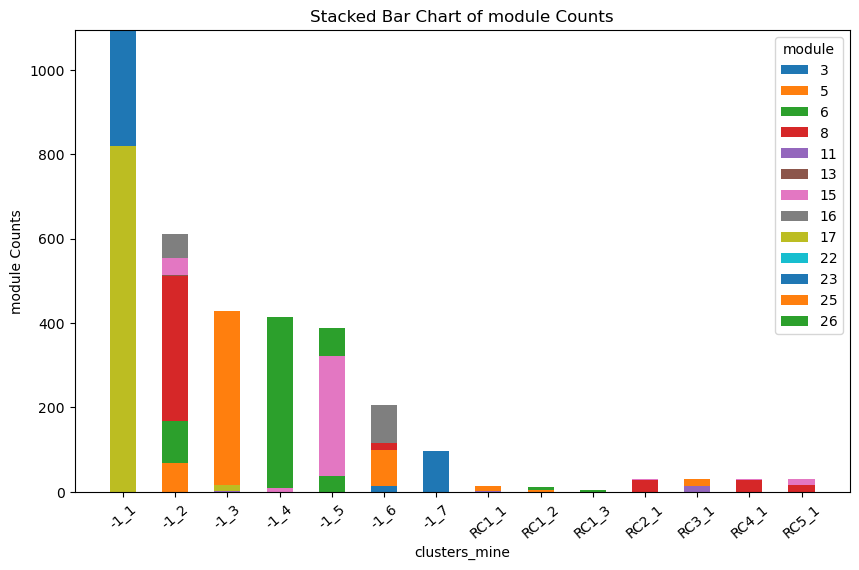

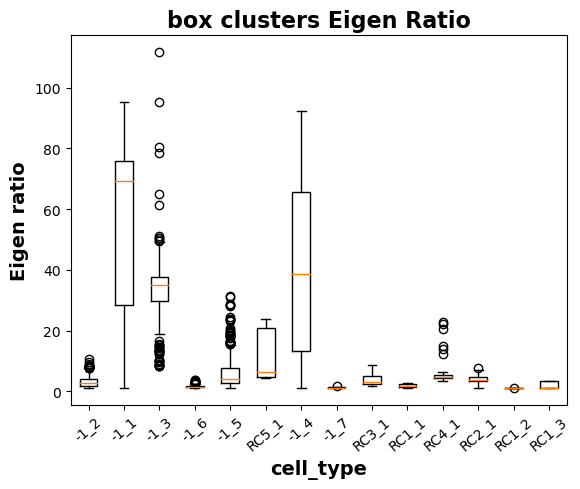

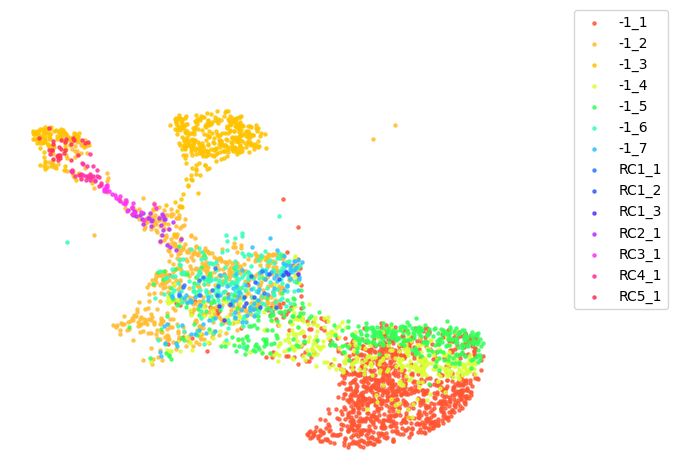

In [ ]:

clusters_mine = []
ktime = {}
for k,i in enumerate(clusters):
    if i in ktime:
        ktime[i] = ktime[i]+1
    else:
        ktime[i] = 0
    clusters_mine.append(f'{i}_{TT[i][ktime[i]]}')
clusters_mine = np.array(clusters_mine)
eigenvec_mine = {}
for i in categories:
    for j in TT[i]:
        eigenvec_mine[f'{i}_{j}'] = eigenvec[i][TT[i] == j]

colors_hex = [
    "#FF5733", "#FFBD33", "#FFC300", "#DAFF33", "#33FF57", 
    "#33FFBD", "#33C1FF", "#337BFF", "#335BFF", "#5733FF", 
    "#BD33FF", "#FF33F6", "#FF33A1", "#FF335B", "#FF5733", 
    "#FF8D33", "#FF3333", "#FF6633", "#FF9933", "#FFFF33", 
    "#BFFF33", "#33FF8D", "#33FF99", "#33FFFF", "#3399FF", 
    "#3366FF", "#6633FF", "#9933FF", "#FF33C4", "#FF33A1", 
    "#FF5733", "#FF8D33"
]

# 转换为NumPy数组
colors_np = np.array(colors_hex)
colors_np = np.hstack((colors_np,colors_np))
# 打印结果
print(colors_np)

data = {}
for i in np.unique(clusters_mine):
    data[i] = np.argmax(eigenvec_mine[i],axis=1)

# 统计每组中不同元素的个数
labels = list(data.keys())
element_counts = {}
for group, elements in data.items():
    unique, counts = np.unique(elements, return_counts=True)
    element_counts[group] = dict(zip(unique, counts))

# 转换为DataFrame格式以便绘图
elements = list(set().union(*[set(v.keys()) for v in element_counts.values()]))
counts_matrix = np.zeros((len(labels), len(elements)))

for i, group in enumerate(labels):
    for j, element in enumerate(elements):
        counts_matrix[i, j] = element_counts[group].get(element, 0)

# 绘制堆叠柱状图
plt.figure(figsize=(10, 6))
bar_width = 0.5
bottoms = np.zeros(len(labels))

# 绘制每个元素的堆叠柱
for j in range(len(elements)):
    plt.bar(labels, counts_matrix[:, j], width=bar_width, bottom=bottoms, label=elements[j])
    bottoms += counts_matrix[:, j]

plt.xticks(rotation=40)
# 添加标签和图例
plt.xlabel('clusters_mine')
plt.ylabel('module Counts')
plt.title('Stacked Bar Chart of module Counts')
plt.legend(title='module')
plt.show()

PLT_box(clusters_mine,(Eigenval[:,0]/Eigenval[:,1]).reshape((X.shape[0],1)),save_path=result_path_eigenvec+f'box Eigen Ratio {new_para_name}_mine'+'.png',
           ylabel='Eigen ratio',title_name='box clusters Eigen Ratio',cell_sort=cell_vpt)
np.random.seed(42)
for k,i in enumerate(np.unique(clusters_mine)):
    plt.scatter(X_plt[clusters_mine==i],Y_plt[clusters_mine==i], s= 5,c = colors_np[k],alpha=0.8,
                cmap='Spectral',label=f'{i}')

# plt.title('Embedding by TSNE', fontsize=24)
plt.legend(bbox_to_anchor=(1.34,0.4),loc='lower right')
plt.axis('off')
plt.savefig(result_path_eigenvec+'clusters_mine.png',bbox_inches='tight')
plt.show()

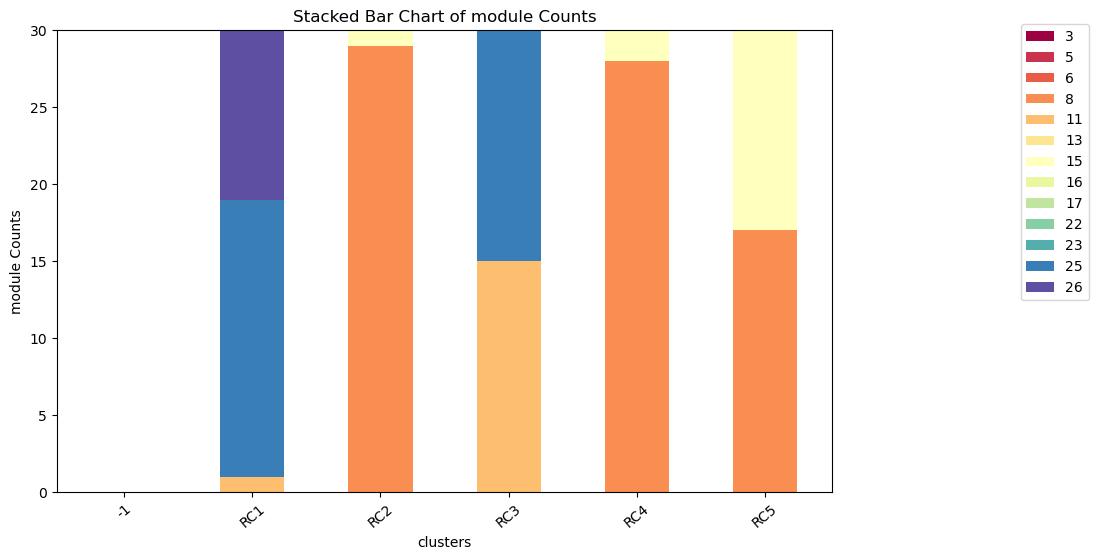

In [ ]:
######cluster_mine
data = {}
for i in np.unique(clusters):
    data[i] = np.argmax(eigenvec[i],axis=1)
# 统计每组中不同元素的个数
labels = list(data.keys())
element_counts = {}
for group, elements in data.items():
    unique, counts = np.unique(elements, return_counts=True)
    element_counts[group] = dict(zip(unique, counts))

# 转换为DataFrame格式以便绘图
elements = list(set().union(*[set(v.keys()) for v in element_counts.values()]))
counts_matrix = np.zeros((len(labels), len(elements)))

for i, group in enumerate(labels):
    if group == str(-1):
        continue
    for j, element in enumerate(elements):
        counts_matrix[i, j] = element_counts[group].get(element, 0)

# 绘制堆叠柱状图
plt.figure(figsize=(10, 6))
bar_width = 0.5
bottoms = np.zeros(len(labels))
color_stackedbar = plt.get_cmap('Spectral')(np.linspace(0, 1, len(elements))) 
# 绘制每个元素的堆叠柱
for j in range(len(elements)):
    plt.bar(labels, counts_matrix[:, j], width=bar_width, bottom=bottoms, label=elements[j],color=color_stackedbar[j])
    bottoms += counts_matrix[:, j]

plt.xticks(rotation=40)
# 添加标签和图例
plt.xlabel('clusters')
plt.ylabel('module Counts')
plt.title('Stacked Bar Chart of module Counts')
plt.legend(title='module')
plt.legend(bbox_to_anchor=(1.34,0.4),loc='lower right')
plt.savefig(result_path_eigenvec+f'stack bar of coordinate',dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
categories

array(['-1', 'RC1', 'RC2', 'RC3', 'RC4', 'RC5'], dtype='<U4')

plot the new vector

In [ ]:
##移动之后的新向量，保存方法是字典
colors = colors_np
if 'RC' in path_name:
    n_points = len(average_path)
    colors = np.linspace(0, 1, n_points)
    cool_cmap = plt.cm.get_cmap('cool')
    colors = cool_cmap(colors)
newvec={}
startvec={}
color_cl = {}
k=0
for i in categories:
    if i == str(-1):
        color_cl[i] = np.array([128/256,128/256,128/256,1])
        continue
    newvec[i] ,startvec[i] = [],[]
    color_cl[i] = colors[k]
    k+=1
    cell_i = np.mean(X[clusters==i],axis=0)
    for j in set(TT[i]):
        vec_j = np.mean(eigenvec[i][TT[i]==j],axis=0)
        newvec[i].append(cell_i + 0.1*vec_j)
        startvec[i].append(cell_i)

##聚类颜色
color_cell = []
for i in range(len(X)):
    color_cell.append(color_cl[clusters[i]])

C:\Users\WINDOWS\AppData\Local\Temp\ipykernel_10540\3667948987.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cool_cmap = plt.cm.get_cmap('cool')


4 16 26


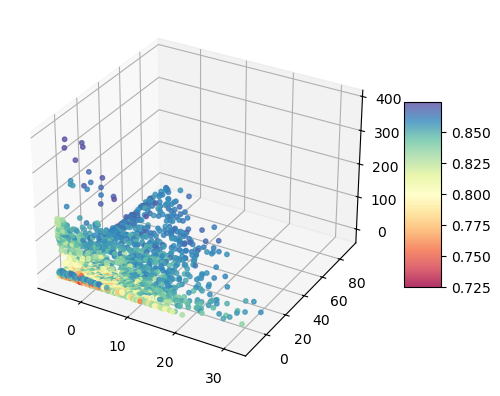

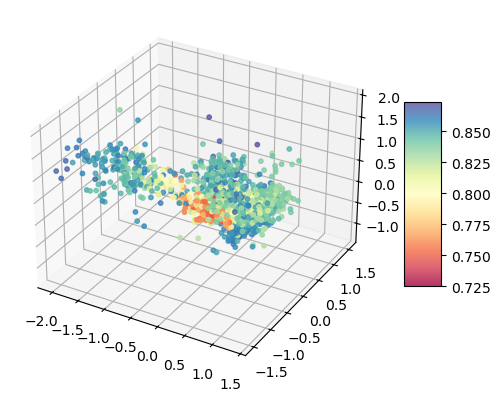

In [ ]:
if X.shape[1]>2:
    max1,max2,max3 = np.argsort(np.mean(X**2,axis=0))[-3:]
    # max1,max2,max3 = np.argsort(np.mean(X**2,axis=0))[:3]
    print(max1,max2,max3)
    plot3d(X[:,max1], X[:,max2], X[:,max3],
       color=crc_smooth,color_bar_name='',save_name=result_path + f'cl on {new_para_name}{K}_{L}.png')
    
###CRC ON EMBEDDIGN
if L>2:
    max1,max2,max3 = np.argsort(np.mean(sigma_learned**2,axis=0))[-3:]
    # max1,max2,max3 = np.argsort(np.mean(sigma_learned**2,axis=0))[:3]
    plot3d(mu_learned[:,max1], mu_learned[:,max2], mu_learned[:,max3],
       color=crc_smooth,color_bar_name='',save_name=result_path + f'cl on embedding{K}_{L}.png')

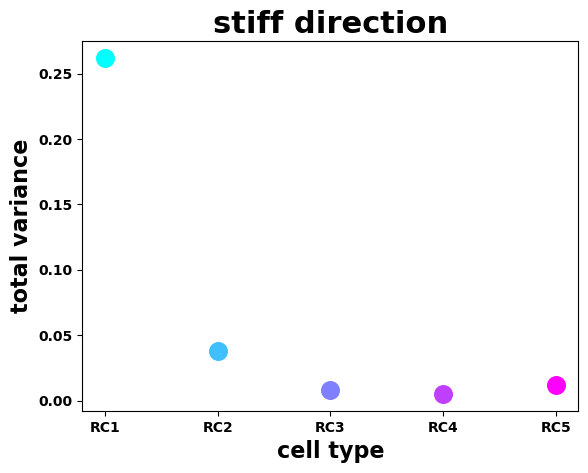

In [ ]:
#variance of parameter velocity
k=0
if 'Other Glia' in categories:
    categories_new=np.delete(categories, np.where(categories == 'Other Glia'))
elif str(-1) in categories:
    categories_new=np.delete(categories, np.where(categories == str(-1)))
else:
    categories_new = categories
for i in categories_new:
    # vec_corr = eigenvec[i]@eigenvec[i].T
    # plt.scatter(k,np.trace(vec_corr),label=i,s=10)
    plt.scatter(k,np.sum(np.var(eigenvec[i],axis=0)),label=i,s=160,c=color_cl[i],cmap='cool')
    k+=1
plt.title('stiff direction', fontsize=22,weight='bold')
plt.xticks(range(len(categories_new)),categories_new,weight='bold')
plt.yticks(weight='bold')
if np.sum([len(str(i)) for i in categories_new])>50:
    plt.xticks(rotation=40,weight = 'bold')
# plt.legend()

plt.xlabel('cell type',fontsize=16,weight='bold')
plt.ylabel("total variance",fontsize=16,weight='bold')
plt.savefig(result_path_eigenvec+f'variance of eigenvec',dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
####cluster内整体正负号调整
newvec={}
k=0
for i in categories:
    newvec[i]  = []
    k+=1
    cell_i = np.mean(X[clusters==i],axis=0)
    for j in set(TT[i]):
        vec_j = np.mean(eigenvec[i][TT[i]==j],axis=0)
        newvec[i].append(cell_i + 0.1*vec_j)
    newvec[i] = np.array(newvec[i])

Epoch:9, train_loss:18.065599, val_loss:16.484533, lr:0.00100
Epoch:19, train_loss:10.321760, val_loss:9.474298, lr:0.00100
Epoch:29, train_loss:7.928718, val_loss:7.161234, lr:0.00100
Epoch:39, train_loss:6.005636, val_loss:5.539100, lr:0.00100
Epoch:49, train_loss:4.422005, val_loss:4.019547, lr:0.00100
Epoch:59, train_loss:3.256097, val_loss:2.988081, lr:0.00100
Epoch:69, train_loss:2.427935, val_loss:2.274529, lr:0.00100
Epoch:79, train_loss:1.943302, val_loss:1.877257, lr:0.00100
Epoch:89, train_loss:1.687266, val_loss:1.665434, lr:0.00100
Epoch:99, train_loss:1.532311, val_loss:1.540918, lr:0.00100
Epoch:109, train_loss:1.417712, val_loss:1.445166, lr:0.00100
Epoch:119, train_loss:1.327990, val_loss:1.373520, lr:0.00100
Epoch:129, train_loss:1.255232, val_loss:1.313940, lr:0.00100
Epoch:139, train_loss:1.195564, val_loss:1.266194, lr:0.00100
Epoch:149, train_loss:1.147197, val_loss:1.225541, lr:0.00100
Epoch:159, train_loss:1.108647, val_loss:1.189561, lr:0.00100
Epoch:169, train

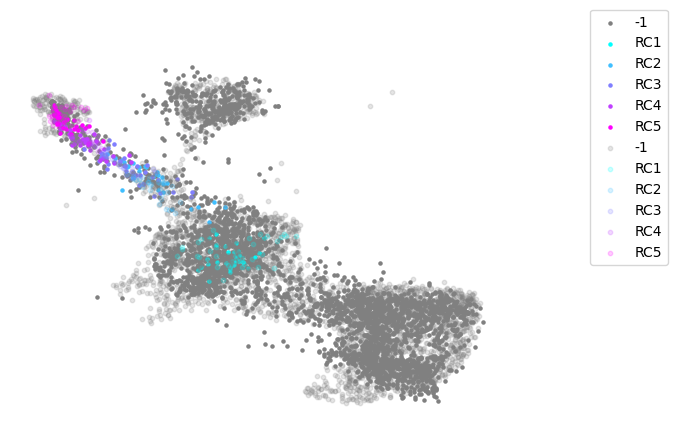

In [ ]:

# 1. 模型定义
model = nn.Sequential(
    nn.Linear(X.shape[1], 128),
    nn.ReLU(),
    nn.Linear(128,64),
    nn.ReLU(),
    nn.Linear(64,2),
)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 推荐自动学习率衰减调度器
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=4, verbose=True)

# vstack保证Y_plt是N,2
XY_plt = np.vstack((X_plt,Y_plt)).T

# split data
train_idx, test_idx = train_test_split(X.shape[0], train_ratio=0.7)
X_train, X_test = X[train_idx], X[test_idx]
Y_train, Y_test = XY_plt[train_idx], XY_plt[test_idx]

patience = 20  # 更稳健一点的early stopping
best_loss = float('inf')
counter = 0
max_epochs = 300

epoch = 0
while epoch < max_epochs:
    # train
    model.train()
    x_in = torch.tensor(X_train.astype(np.float32))
    x_out = torch.tensor(Y_train.astype(np.float32))
    output = model(x_in)
    train_loss = loss_fn(output, x_out)

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    # eval
    model.eval()
    with torch.no_grad():
        test_in = torch.tensor(X_test.astype(np.float32))
        test_out = model(test_in)
        val_loss = loss_fn(test_out, torch.tensor(Y_test.astype(np.float32)))

    scheduler.step(val_loss)

    # Early Stopping
    if val_loss < best_loss - 1e-6:   # 增加一个最小改善阈值，避免浮点误差反复
        best_loss = val_loss
        counter = 0
    else:
        counter += 1
    if counter >= patience:
        print(f"Early stopping at epoch {epoch}, best val loss: {best_loss.item():.6f}")
        break

    if epoch % 10 == 9:
        print(f"Epoch:{epoch}, train_loss:{train_loss.item():.6f}, val_loss:{val_loss.item():.6f}, lr:{optimizer.param_groups[0]['lr']:.5f}")
    epoch += 1

###
np.random.seed(42)
for k,i in enumerate(np.unique(clusters)):
    sub_XY_plt = model(torch.tensor(X[clusters==i])).detach().numpy()
    
    plt.scatter(sub_XY_plt[:,0],sub_XY_plt[:,1], s= 5,c = color_cl[i],alpha=1,
                cmap='Spectral',label=f'{i}')
for i in categories:
    plt.scatter(X_plt[clusters==i],Y_plt[clusters==i], s= 10,c = color_cl[i],alpha=0.2,
                cmap='Spectral',label=f'{i}')
plt.legend(bbox_to_anchor=(1.34,0.4),loc='lower right')
plt.axis('off')
# plt.savefig(result_path_eigenvec+'clusters_eigenvec.png',bbox_inches='tight')
plt.show()



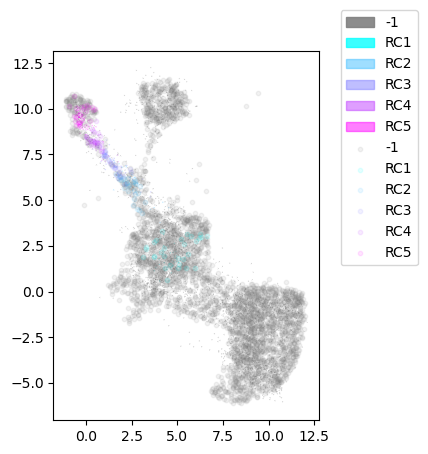

In [ ]:
##箭头图
eta = 1e-2
for i in categories:
    start_embedding = model(torch.tensor(X[clusters==i])).detach().numpy()
    # start_embedding = np.vstack((X_plt,Y_plt)).T[clusters==i]
    test_embedding = model(torch.tensor(X[clusters==i]+eta*eigenvec[i].astype(np.float32))).detach().numpy()
    if i in ['5','7','11']:
        test_embedding = model(torch.tensor(X[clusters==i]-eigenvec[i].astype(np.float32))).detach().numpy()

    for j in range(len(start_embedding)):
        # if np.sum(TT[i] == TT[i][j])/len(TT[i]) < 0.01:
        #     continue
        ### 一定概率显示箭头
        # if np.random.rand() > 0.3:
        #     continue
        lenvecj = np.linalg.norm(test_embedding[j] - start_embedding[j])/np.sum(TT[i] == TT[i][j])*len(TT[i])
        plt.arrow(start_embedding[j,0],start_embedding[j,1],
                  (test_embedding[j,0] - start_embedding[j,0])/lenvecj*0.01,
                  (test_embedding[j,1] - start_embedding[j,1])/lenvecj*0.01,
                  color=color_cl[i],alpha=1-0.5*np.sum(TT[i] == TT[i][j])/len(TT[i]),
                  label=f'{i}' if j==0 else None)
for i in categories:
    plt.scatter(X_plt[clusters==i],Y_plt[clusters==i], s= 10,c = color_cl[i],alpha=0.1,
                cmap='Spectral',label=f'{i}')
    #plt.title(i,fontsize=15,weight='bold')
plt.gca().set_aspect('equal')
plt.legend(bbox_to_anchor=(1.4,0.4),loc='lower right')
plt.show()

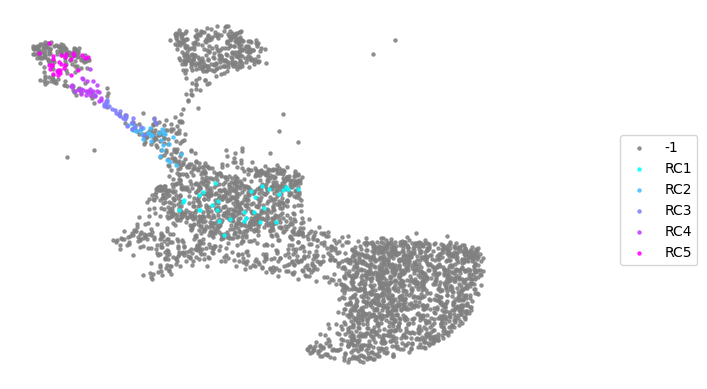

In [ ]:
np.random.seed(42)
for i in categories:
    plt.scatter(X_plt[clusters==i],Y_plt[clusters==i], s= 5,c = color_cl[i],alpha=0.8,
                cmap='Spectral',label=f'{i}')

plt.legend(bbox_to_anchor=(1.4,0.29),loc='lower right')
plt.axis('off')
plt.savefig(result_path_eigenvec+'TSNE_eigenvector.png',bbox_inches='tight')
plt.show()

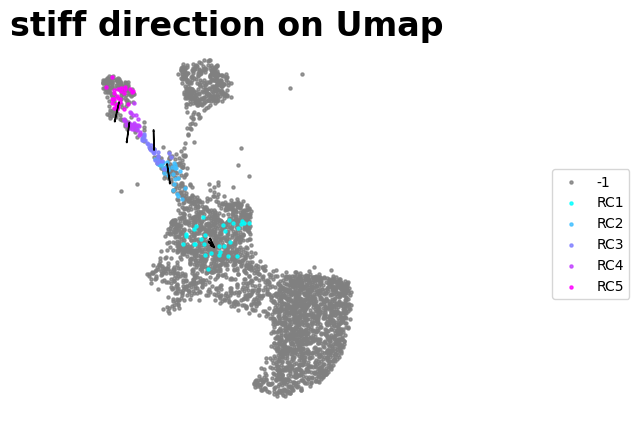

In [ ]:
## 在cluster平均点画箭头
eta=1
np.random.seed(42)
for i in categories:
    plt.scatter(X_plt[clusters==i],Y_plt[clusters==i], s= 5,c = color_cl[i],alpha=0.8,
                cmap='Spectral',label=f'{i}')
for i in newvec:
    if i == str(-1):
        continue
    start_embedding = model(torch.tensor(startvec[i])).detach().numpy()
    test_embedding = model(torch.tensor(newvec[i].astype(np.float32))).detach().numpy()
    for j in range(len(set(TT[i]))):
        if np.sum(TT[i]==list(set(TT[i]))[j])/len(TT[i])<0.01:
            continue
        lenvecj = np.linalg.norm(test_embedding[j] - start_embedding[j])/np.sum(TT[i]==list(set(TT[i]))[j])*len(TT[i])
    #plt.scatter(test_embedding[:, 0], test_embedding[:, 1], s= 50, c='grey',cmap='Spectral')
        plt.arrow(start_embedding[j, 0], start_embedding[j, 1],
                (test_embedding[j, 0] - start_embedding[j, 0])/lenvecj*eta,
                (test_embedding[j, 1] - start_embedding[j, 1])/lenvecj*eta,width=0.02)
plt.title('stiff direction on Umap', fontsize=24,weight='bold')
plt.gca().set_aspect('equal')
plt.axis('off')
plt.legend(bbox_to_anchor=(2,0.29),loc='lower right')
# plt.savefig(result_path+'TSNE_eigenvector.png')
plt.show()

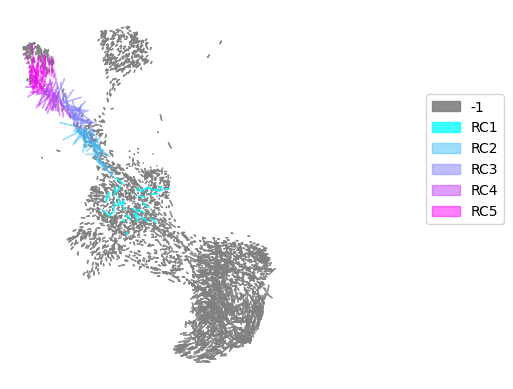

In [ ]:
##箭头图
eta = 1
for i in categories:
    # start_embedding = model(torch.tensor(X[clusters==i])).detach().numpy()
    start_embedding = np.vstack((X_plt,Y_plt)).T[clusters==i]
    test_embedding = model(torch.tensor(X[clusters==i]+eigenvec[i].astype(np.float32))).detach().numpy()
    if i in ['5','7','11']:
        test_embedding = model(torch.tensor(X[clusters==i]-eigenvec[i].astype(np.float32))).detach().numpy()
    # plt.quiver(0, 0,
    #            test_embedding[:, 0] - start_embedding[:, 0],test_embedding[:, 1] - start_embedding[:, 1],
    #            scale=0.3)
    # plt.title('Embedding by TSNE', fontsize=24)
    # plt.legend(bbox_to_anchor=(1.34,0.4),loc='lower right')
    # plt.savefig(result_path+'TSNE_eigenvector.png')
    # plt.show()

    for j in range(len(start_embedding)):
        if np.sum(TT[i] == TT[i][j])/len(TT[i]) < 0.01:
            continue
        lenvecj = np.linalg.norm(test_embedding[j] - start_embedding[j])/np.sum(TT[i] == TT[i][j])*len(TT[i])
        plt.arrow(start_embedding[j,0],start_embedding[j,1],
                  (test_embedding[j,0] - start_embedding[j,0])/lenvecj*eta,
                  (test_embedding[j,1] - start_embedding[j,1])/lenvecj*eta,
                  color=color_cl[i],alpha=1-0.5*np.sum(TT[i] == TT[i][j])/len(TT[i]),
                  label=f'{i}' if j==0 else None)
        
    #plt.title(i,fontsize=15,weight='bold')
plt.gca().set_aspect('equal')
plt.axis('off')
plt.legend(bbox_to_anchor=(1.8,0.4),loc='lower right')
plt.show()

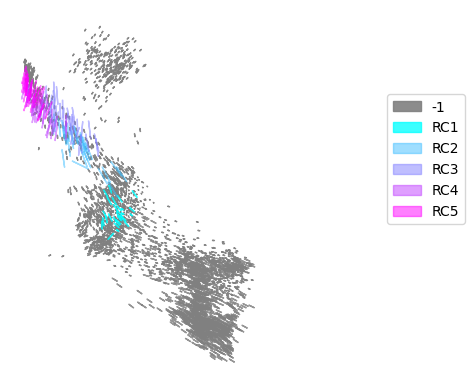

In [ ]:
##箭头图
eta = 1
for i in categories:
    start_embedding = model(torch.tensor(X[clusters==i])).detach().numpy()
    # start_embedding = np.vstack((X_plt,Y_plt)).T[clusters==i]
    test_embedding = model(torch.tensor(X[clusters==i]+eigenvec[i].astype(np.float32))).detach().numpy()
    if i in ['5','7','11']:
        test_embedding = model(torch.tensor(X[clusters==i]-eigenvec[i].astype(np.float32))).detach().numpy()
    # plt.quiver(0, 0,
    #            test_embedding[:, 0] - start_embedding[:, 0],test_embedding[:, 1] - start_embedding[:, 1],
    #            scale=0.3)
    # plt.title('Embedding by TSNE', fontsize=24)
    # plt.legend(bbox_to_anchor=(1.34,0.4),loc='lower right')
    # plt.savefig(result_path+'TSNE_eigenvector.png')
    # plt.show()

    for j in range(len(start_embedding)):
        if np.sum(TT[i] == TT[i][j])/len(TT[i]) < 0.01:
            continue
        lenvecj = np.linalg.norm(test_embedding[j] - start_embedding[j])/np.sum(TT[i] == TT[i][j])*len(TT[i])
        plt.arrow(start_embedding[j,0],start_embedding[j,1],
                  (test_embedding[j,0] - start_embedding[j,0])/lenvecj*eta,
                  (test_embedding[j,1] - start_embedding[j,1])/lenvecj*eta,
                  color=color_cl[i],alpha=1-0.5*np.sum(TT[i] == TT[i][j])/len(TT[i]),
                  label=f'{i}' if j==0 else None)
        
    #plt.title(i,fontsize=15,weight='bold')
plt.gca().set_aspect('equal')
plt.axis('off')
plt.legend(bbox_to_anchor=(1.8,0.4),loc='lower right')
plt.show()

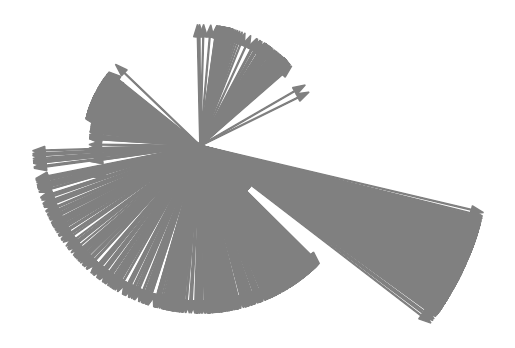

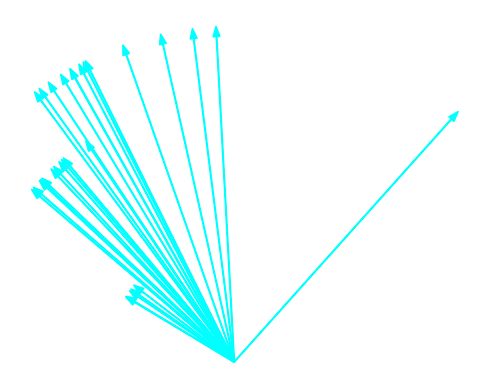

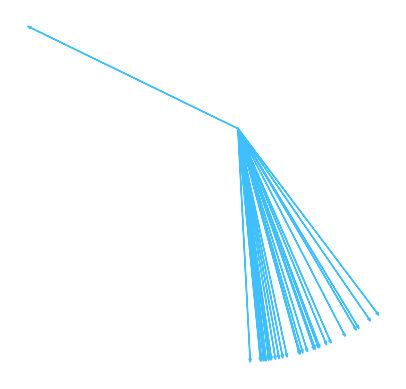

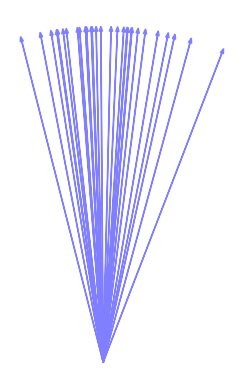

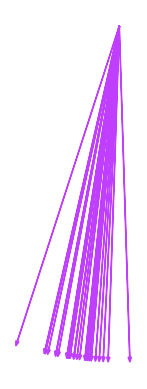

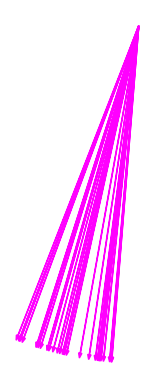

In [ ]:
#####神经网络得到可视化的箭头
for i in categories:
    start_embedding = model(torch.tensor(X[clusters==i])).detach().numpy()
    test_embedding = model(torch.tensor(X[clusters==i]+eigenvec[i].astype(np.float32))).detach().numpy()
    if i in ['5','7','11']:
        test_embedding = model(torch.tensor(X[clusters==i]-eigenvec[i].astype(np.float32))).detach().numpy()
    # plt.quiver(0, 0,
    #            test_embedding[:, 0] - start_embedding[:, 0],test_embedding[:, 1] - start_embedding[:, 1],
    #            scale=0.3)
    # plt.title('Embedding by TSNE', fontsize=24)
    # plt.legend(bbox_to_anchor=(1.34,0.4),loc='lower right')
    # plt.savefig(result_path+'TSNE_eigenvector.png')
    # plt.show()

    for j in range(len(start_embedding)):
        if np.sum(TT[i] == TT[i][j])/len(TT[i]) < 0.05:
            continue
        lenvecj = np.linalg.norm(test_embedding[j] - start_embedding[j])/np.sum(TT[i] == TT[i][j])*len(TT[i])
        plt.arrow(0,0,(test_embedding[j,0] - start_embedding[j,0])/lenvecj,
                  (test_embedding[j,1] - start_embedding[j,1])/lenvecj,
                  color=color_cl[i],head_width=0.01,
                  label=f'{i}' if j==0 else None)
        
    #plt.title(i,fontsize=15,weight='bold')
    plt.gca().set_aspect('equal')
    # plt.legend()
    plt.axis('off')
    plt.savefig(result_path_eigenvec+f'arrow of {i}.png')
    plt.show()

In [ ]:
TT_eigen = my_Rearrange(T_eigen)


In [ ]:
for i in range(X.shape[1]):
    print(T_eigen[TT_eigen == i+1][0]-1,len(T_eigen[TT_eigen == i+1]))

21 131
26 99
16 79
19 62
18 58
27 23
24 17
25 17
2 15
0 12
14 8
20 8
4 7
10 7
11 7
8 6
13 6
5 5
12 5
3 4
7 4
9 4
15 4
22 4
1 2
6 2
17 2
23 1
28 1


d:\Anaconda\envs\pytorch\Lib\site-packages\pandas\core\algorithms.py:516: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps.dtype], [])
d:\Anaconda\envs\pytorch\Lib\site-packages\pandas\core\algorithms.py:516: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps.dtype], [])
d:\Anaconda\envs\pytorch\Lib\site-packages\pandas\core\algorithms.py:516: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Depr

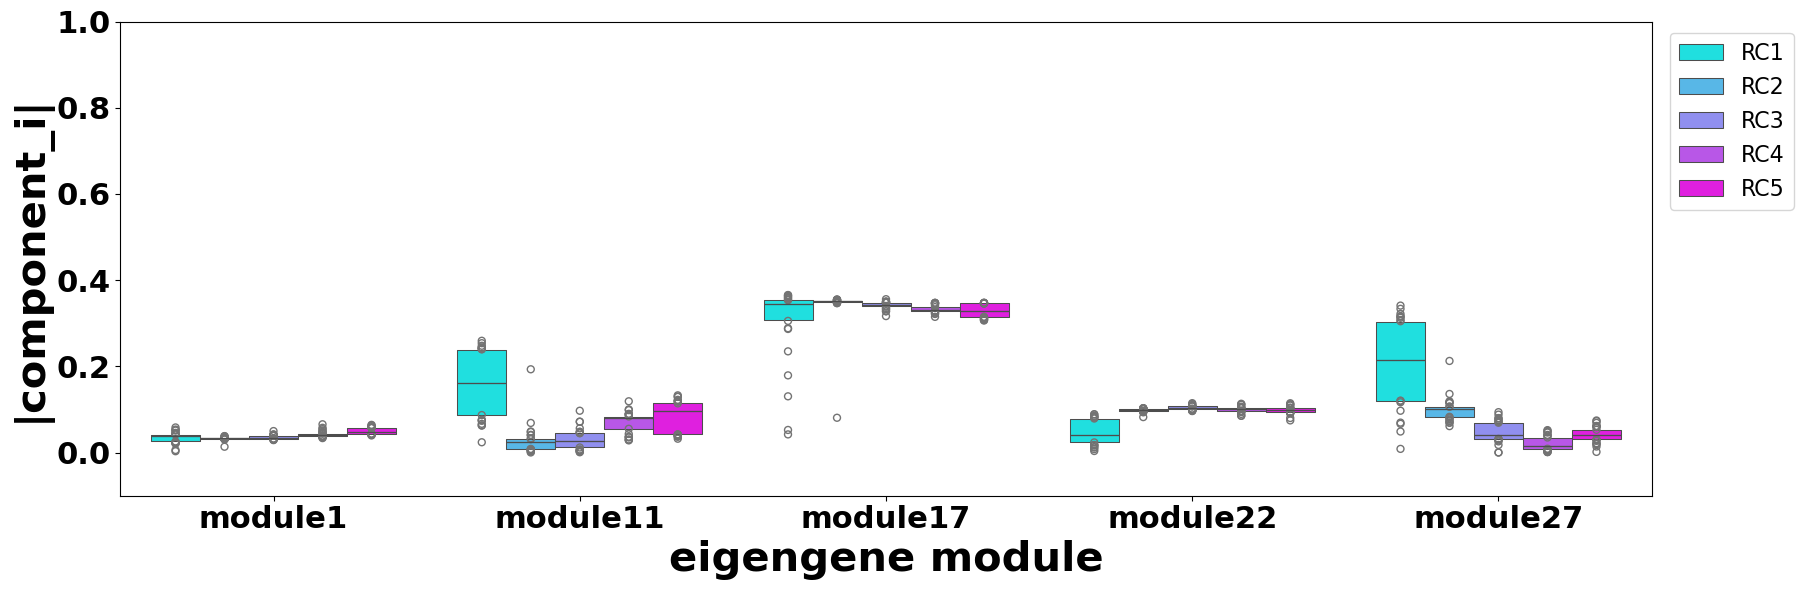

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# 假设 data_dict 已给定
records = []
for group, mat in eigenvec.items():
    if group == str(-1):
        continue
    n, d = mat.shape
    for dim in range(d):
        for val in mat[:, dim]:
            records.append({
                'cell type': group,
                '维度': f'module{dim+1}',  # 或直接用数字
                '分量值': np.abs(val)
            })
df = pd.DataFrame(records)
df_cut = df[df['维度'].isin([f'module{i+1}' for i in range(100)])]
df_cut = df[df['维度'].isin([f'module{i+1}' for i in [21,26,16,0,10]])]
plt.figure(figsize=(max(18, len(df_cut['维度'].unique())*3), 6))  # 自动宽度
sns.boxenplot(x='维度', y='分量值', hue='cell type', data=df_cut,palette=color_cl)
plt.yticks([0,0.2,0.4,0.6,0.8,1], fontsize=22, weight='bold')
plt.xticks(fontsize=22, weight='bold')
plt.ylim(-0.1,1)
plt.xlabel(f'{new_para_name} module', fontsize=30, weight='bold')
plt.ylabel('|component_i|', fontsize=30, weight='bold')
plt.legend(title=None, fontsize=16,loc='upper right',bbox_to_anchor=(1.1,1))
# if path_name == 'RC/': ##RC 图例改用一个colorbar
#     plt.legend([],[], frameon=False)
plt.tight_layout()
plt.savefig(result_path_eigenvec+'Boxenplot of Eigenvec Components.png', bbox_inches='tight')
plt.show()

In [ ]:
###
# tf_stiffnum = np.zeros(X.shape[0])
pZ_pX = np.zeros([X.shape[0], L*2, X.shape[1]])
Eigenvec2 = np.zeros((X.shape[0],X.shape[1]))   ##1st eigenvec for each cell |(n,m)
for i in range(X.shape[0]):
    pZ_pX[i] = np.vstack((pMu_pX[i],pSgm_pX[i]))
    FIgene_i = pZ_pX[i].T@Fisher_g[i]@pZ_pX[i]
    Eigenvec2[i] = np.linalg.eigh(FIgene_i)[1][:,-2]

In [ ]:
np.max(Eigenvec2[clusters=='RC1']@eigenvec['RC1'].T)

0.9978094660763507

In [ ]:
1- np.min(Eigenvec[clusters_mine=='RC1_1']@Eigenvec[clusters_mine=='RC1_1'].T)

0.14879734048480753

In [ ]:
1-np.cos(np.pi/6),t_new,result_path_eigenvec

(0.1339745962155613,
 0.6389930918812752,
 'results/zebrafish/junda/k_nei=10/K=3 L=6/RC_P2M_xiaohe/eigengene_Eigenvec/')

RC1_1 0.3314883348666933
RC1_2 0.5335625674303817
RC1_3 0.5631017782555489


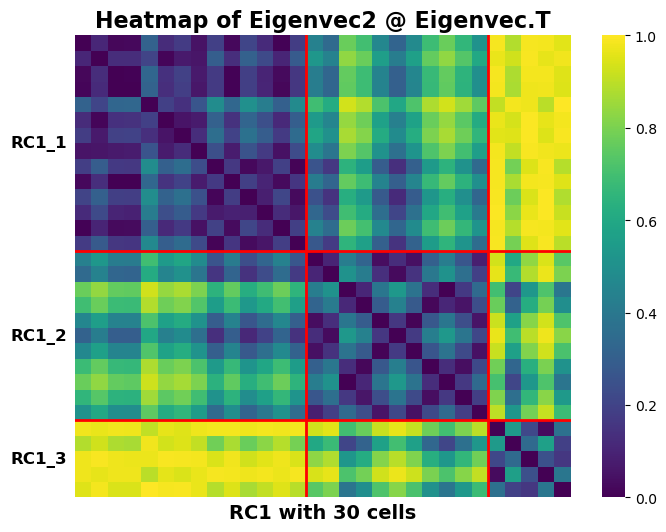

RC2_1 0.9229078239470531


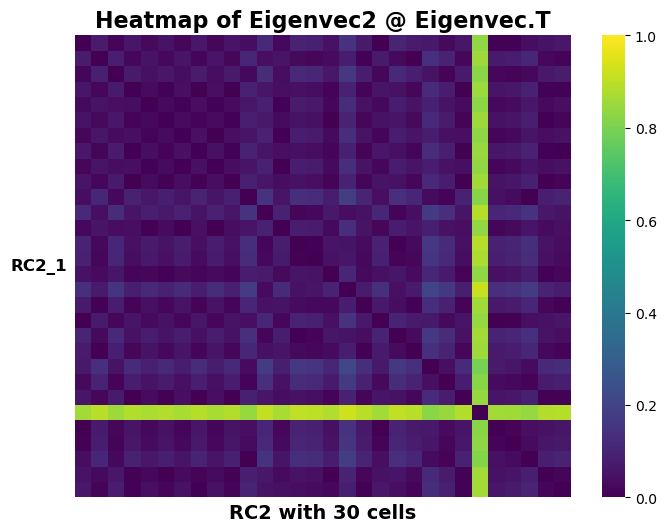

RC3_1 0.3469654904727895


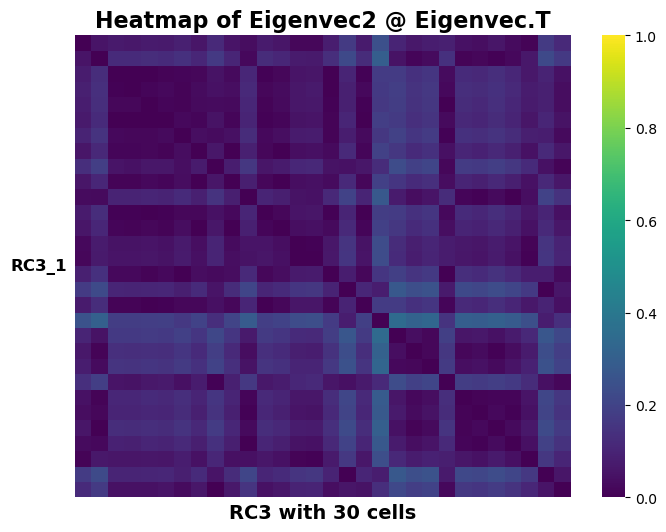

RC4_1 0.23234360797555395


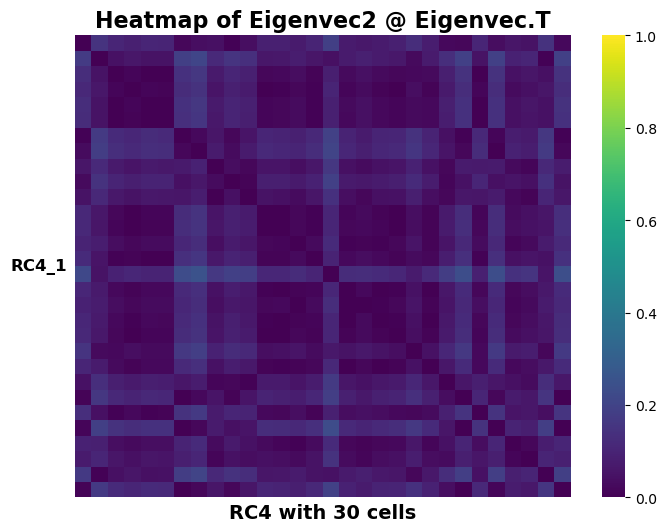

RC5_1 0.15148723430071617


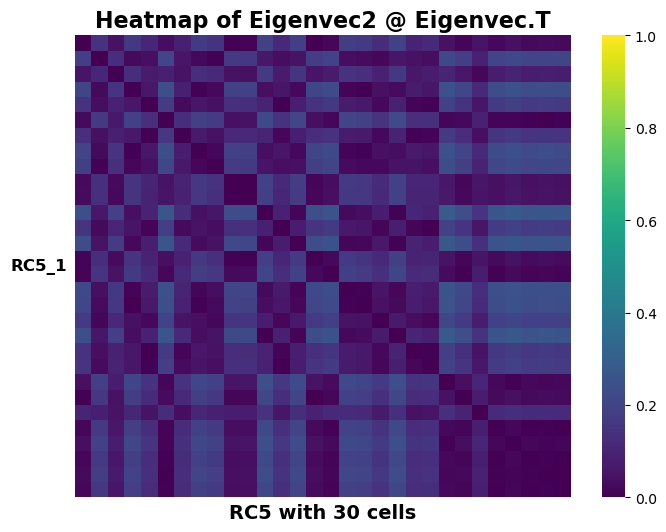

In [ ]:
for cells in categories:
    if cells == str(-1):
        continue
    a = []
    b = []
    group_sizes = []
    part_names = []
    for spilit_cells in np.unique(clusters_mine):
        if '-1' in str(spilit_cells):
            continue 
        if str(cells)+'_' not in str(spilit_cells):
            continue
        a_group = Eigenvec[clusters_mine==spilit_cells]
        b_group = Eigenvec2[clusters_mine==spilit_cells]
        print(spilit_cells,np.max(b_group@a_group.T))
        a.append(a_group)
        b.append(b_group)
        group_sizes.append(len(b_group))
        part_names.append(str(spilit_cells))
    a = np.vstack(a)
    b = np.vstack(b)
    c = b @ a.T
    # print(np.max(c))
    boundaries = np.cumsum(group_sizes)
    y_lines = boundaries[:-1]

    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(np.abs(c), cmap='viridis', vmin=0, vmax=1)
    plt.xticks([])
    plt.yticks([])
    plt.title('Heatmap of Eigenvec2 @ Eigenvec.T', fontsize=16, weight='bold')
    plt.xlabel(f'{cells} with {np.sum(clusters==cells)} cells', fontsize=14, weight='bold')

    # 画分界线
    for y in y_lines:
        ax.axhline(y, color='red', lw=2)
    for x in y_lines:
        ax.axvline(x, color='red', lw=2)
    # 标注文字
    y_start = 0
    for size, name in zip(group_sizes, part_names):
        y_center = y_start + size / 2
        ax.text(-0.5, y_center, name, va='center', ha='right', fontsize=12, color='black', weight='bold')
        y_start += size
    plt.savefig(result_path_eigenvec+f'Heatmap of Eigenvec2 @ Eigenvec.T {cells}.png', bbox_inches='tight')
    plt.show()